In [5]:
# Importing important libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import json
import folium
from folium.plugins import HeatMapWithTime
from folium.plugins import HeatMap
import os.path
from os import path
import matplotlib.cm as cm
import warnings
from matplotlib.ticker import MultipleLocator
warnings.filterwarnings('ignore')
from time import process_time
from time import perf_counter



In [6]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("poster", rc={'grid.color': 'black', "grid.linewidth": 2, 'lines.markersize':15})

In [7]:
def filter_df(df,  startdate, enddate):
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'],format='%Y-%m-%d %H:%M:%S', errors='coerce')
    df = df.loc[(df['tpep_pickup_datetime'] >= startdate)& (df['tpep_pickup_datetime'] < enddate)]
    return df

In [8]:
def parse_timestamp(df, freq='15 min'):
    
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'],format='%Y-%m-%d %H:%M:%S', errors='coerce')
    df['Timestamp'] = pd.to_datetime(df['tpep_pickup_datetime'].dt.round(freq = freq))
    
    df['Date'] = (df['Timestamp']).dt.date
    df['Time'] = (df['Timestamp']).dt.time
    df['Day'] = df['tpep_pickup_datetime'].dt.strftime('%A')
    
    return df

In [65]:
# Getting the max and min latitude and longitude to filter data 

with open('./Boundaries/Borough Boundaries.geojson') as f:
    js = json.load(f)
# Getting a list of Manhattan coordinates and flattening the list of list of list of list
man_cord_list = js['features'][4]['geometry']['coordinates']
man_cord_flat = [item for sublist in man_cord_list for item in sublist]
man_cord_flat2 = [item for sublist in man_cord_flat for item in sublist]

max_lt,max_lng,min_lt,min_lng =0,0,999,999
for lat,lng in man_cord_flat2:
    
    if abs(lat) > max_lng:
        max_lng = lat
    if abs(lng) > max_lt: 
        max_lt = lng
    if abs(lat) < min_lng:
        min_lng = lat
    if abs(lng) < min_lt: 
        min_lt = lng
print(max_lng, max_lt, min_lng, min_lt)

-73.90665099473267 40.87903804730722 -74.01092841268031 40.68291694544512


In [10]:
def process_df(df):
    #Keeping only the columns required
    df = df[['pickup_latitude' ,'pickup_longitude','dropoff_latitude' , 
             'dropoff_longitude','tpep_pickup_datetime','total_amount' , 
             'passenger_count' ,'Date', 'Time','total_amount','Day' ]].copy()
    
    # Removing all zero entries
    df = df[(df != 0).all(1)]
    
    # Removing all passengers 5 and above
    df = df.loc[(df['passenger_count']>0) & (df['passenger_count']<5)]
    df = df.sort_values(by='tpep_pickup_datetime',kind='heapsort', ascending=True)
    
    # Rough filter to filter out lat,lng further away from Manhattan
    df = df.loc[(df['pickup_latitude']>=min_lt) & (df['pickup_latitude']<= max_lt) & 
                (df['pickup_longitude']>=min_lng) & (df['pickup_longitude']<= max_lng)]
    df = df.loc[(df['dropoff_latitude']>=min_lt) & (df['dropoff_latitude']<= max_lt) & 
                (df['dropoff_longitude']>=min_lng) & (df['dropoff_longitude']<= max_lng)]
    
    df = df.round(4)    

    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

### Data Source - https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-06.csv
 I downloaded the data on local drive as seen below

In [11]:
start_date = pd.to_datetime("2016-06-06").date()
end_date = pd.to_datetime("2016-06-13").date()

fpath = "./Data/Pickled Data/YC_2016_Jun_Wk1_Prep.pkl"
if path.exists(fpath):
    yc_2016_jun_wk1_prep = pd.read_pickle(fpath)
else:
    trips_yc_2016_june = pd.read_csv('./Data/trip_data/yellow_tripdata_2016-06.csv' , low_memory=False)
    yc_2016_jun_wk1_raw = filter_df(trips_yc_2016_june, start_date, end_date)
    yc_2016_jun_wk1_prep = process_df(parse_timestamp(yc_2016_jun_wk1_raw))
    
    dpath ='./Data/Pickled Data/'
    os.makedirs(dpath, exist_ok=True) 
    yc_2016_jun_wk1_prep.to_pickle(dpath + 'YC_2016_Jun_Wk1_Prep.pkl')
yc_2016_jun_wk1_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019695 entries, 0 to 2019694
Data columns (total 11 columns):
pickup_latitude         float64
pickup_longitude        float64
dropoff_latitude        float64
dropoff_longitude       float64
tpep_pickup_datetime    datetime64[ns]
total_amount            float64
passenger_count         int64
Date                    object
Time                    object
total_amount            float64
Day                     object
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 169.5+ MB


In [12]:
yc_2016_jun_wk1_prep.head()

pickup_latitude  pickup_longitude  dropoff_latitude  dropoff_longitude  \
0          40.7506          -73.9787           40.7250           -73.9971   
1          40.7851          -73.9465           40.8077           -73.9239   
2          40.7415          -73.9524           40.7209           -74.0041   
3          40.7422          -73.9807           40.7590           -73.9678   
4          40.7563          -73.9868           40.7631           -73.9761   

  tpep_pickup_datetime  total_amount  passenger_count        Date      Time  \
0  2016-06-06 00:00:00         13.35                1  2016-06-06  00:00:00   
1  2016-06-06 00:00:00         21.30                1  2016-06-06  00:00:00   
2  2016-06-06 00:00:00         58.34                1  2016-06-06  00:00:00   
3  2016-06-06 00:00:01          9.12                2  2016-06-06  00:00:00   
4  2016-06-06 00:00:02          6.30                1  2016-06-06  00:00:00   

   total_amount     Day  
0         13.35  Monday  
1         21.30  Monday  
2         58.34  Monday  
3          9.12  Monday  
4          6.30  Monday

In [13]:
# Calculate bearing angle from the pickup to dropoff

def get_bearing(long1, lat1, long2, lat2): 
    long1, lat1, long2, lat2 = map(np.radians, [long1, lat1, long2, lat2])
    bearing = np.arctan2(np.sin(long2-long1)*np.cos(lat2), np.cos(lat1)*np.sin(lat2)-np.sin(lat1)*np.cos(lat2)*np.cos(long2-long1))
    bearing = np.degrees(bearing)
    bearing = (bearing + 360) % 360
    
    return np.round(bearing,2)

# Calculate haversine distance from the pickup to dropoff

def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = 3958.8 * c
    return np.round(distance,2)

In [14]:
# Calculating the Bearing angle and Haversine Distance
# Dividing each feature by 1000 to ensure lower weightage when clustering

yc_2016_jun_wk1_prep['Bearing Angle'] = get_bearing( yc_2016_jun_wk1_prep['pickup_longitude'],
                                                            yc_2016_jun_wk1_prep['pickup_latitude'],
                                                            yc_2016_jun_wk1_prep['dropoff_longitude'],  
                                                            yc_2016_jun_wk1_prep['dropoff_latitude'])/1000
    
yc_2016_jun_wk1_prep['Distance'] = haversine_np(    yc_2016_jun_wk1_prep['pickup_longitude'],
                                                                       yc_2016_jun_wk1_prep['pickup_latitude'],
                                                                       yc_2016_jun_wk1_prep['dropoff_longitude'],  
                                                                       yc_2016_jun_wk1_prep['dropoff_latitude'])/1000

yc_2016_jun_wk1_prep.head()

pickup_latitude  pickup_longitude  dropoff_latitude  dropoff_longitude  \
0          40.7506          -73.9787           40.7250           -73.9971   
1          40.7851          -73.9465           40.8077           -73.9239   
2          40.7415          -73.9524           40.7209           -74.0041   
3          40.7422          -73.9807           40.7590           -73.9678   
4          40.7563          -73.9868           40.7631           -73.9761   

  tpep_pickup_datetime  total_amount  passenger_count        Date      Time  \
0  2016-06-06 00:00:00         13.35                1  2016-06-06  00:00:00   
1  2016-06-06 00:00:00         21.30                1  2016-06-06  00:00:00   
2  2016-06-06 00:00:00         58.34                1  2016-06-06  00:00:00   
3  2016-06-06 00:00:01          9.12                2  2016-06-06  00:00:00   
4  2016-06-06 00:00:02          6.30                1  2016-06-06  00:00:00   

   total_amount     Day  Bearing Angle  Distance  
0         13.35  Monday        0.20858   0.00201  
1         21.30  Monday        0.03712   0.00196  
2         58.34  Monday        0.24228   0.00306  
3          9.12  Monday        0.03018   0.00134  
4          6.30  Monday        0.05000   0.00073

In [15]:
# Filter out Manhatan rides only using Points within polygon method

from matplotlib import path
def fill_boro(df, cord= man_cord_flat2):
    man_cord = []
    for long,lat in cord:
        man_cord.append((long,lat))
    
    polygon = path.Path(man_cord)
    
    pu_point_list = df[['pickup_longitude', 'pickup_latitude']].values.tolist()
    do_point_list = df[['dropoff_longitude', 'dropoff_latitude']].values.tolist()
    
    pu_boro = polygon.contains_points(pu_point_list)
    du_boro = polygon.contains_points(do_point_list)
    boro_list = np.logical_and(pu_boro, du_boro)
       
    df['Manhattan Ride'] = (boro_list).tolist()
    df= df.loc[df['Manhattan Ride'] == True]
    return df

In [16]:
from os import path

fpath = "./Data/Pickled Data/YC_2016_Jun_Wk1_Processed.pkl"
if path.exists(fpath):
    yc_2016_jun_wk1_proc = pd.read_pickle(fpath)
else:
    yc_2016_jun_wk1_proc = fill_boro(yc_2016_jun_wk1_prep)
    os.makedirs(dpath, exist_ok=True) 
    dpath ='./Data/Pickled Data/'
    yc_2016_jun_wk1_proc.to_pickle(dpath + 'YC_2016_Jun_Wk1_Processed.pkl')
    
    
yc_2016_jun_wk1_proc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1123245 entries, 0 to 2019692
Data columns (total 14 columns):
pickup_latitude         1123245 non-null float64
pickup_longitude        1123245 non-null float64
dropoff_latitude        1123245 non-null float64
dropoff_longitude       1123245 non-null float64
tpep_pickup_datetime    1123245 non-null datetime64[ns]
total_amount            1123245 non-null float64
passenger_count         1123245 non-null int64
Date                    1123245 non-null object
Time                    1123245 non-null object
total_amount            1123245 non-null float64
Day                     1123245 non-null object
Bearing Angle           1123245 non-null float64
Distance                1123245 non-null float64
Manhattan Ride          1123245 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(8), int64(1), object(3)
memory usage: 121.0+ MB


In [64]:
with open('./Boundaries/Neighborhood Tabulation Areas.geojson')  as file:
    n_js = json.load(file)

n_dict = dict()
for borough in range(len(n_js['features'])):
    if n_js['features'][borough]['properties']['boro_name'] == 'Manhattan':
        key = n_js['features'][borough]['properties']['ntaname']
        n_dict[key] = n_js['features'][borough]['geometry']['coordinates'][0][0]
   

In [18]:
# Filter out Manhatan rides only using Points within polygon method
def fill_neighborhood(df, n_dict):
    
    x = len(df)
    y = len(list(n_dict.keys()))
    
    n_array = np.full((x,y), False, dtype=bool)
    
    count =0
    pu_point_list = df[['pickup_longitude', 'pickup_latitude']].values.tolist()
    do_point_list = df[['dropoff_longitude', 'dropoff_latitude']].values.tolist()
    for k,v in n_dict.items():
        n_cord = []
        cord = n_dict[k]
        for long,lat in cord:
            n_cord.append((long,lat))
        
        polygon = path.Path(n_cord)
        pu_boro = polygon.contains_points(pu_point_list)
        n_array[:,count] =  pu_boro
        count+=1
    
    drop_index = np.where(~n_array.any(axis=1))
    df = df.drop(df.index[drop_index])
    list_arrays= n_array.nonzero()[1].tolist()
    list_neigh = list(n_dict.keys())
    n_list =([list_neigh[item] for item in list_arrays])
    df['Neighborhood'] = n_list
    return df


In [19]:
from os import path

fpath = "./Data/Pickled Data/YC_2016_Jun_Wk1_Processed_Neighborhood.pkl"
if path.exists(fpath):
    yc_2016_jun_wk1_proc_neigh = pd.read_pickle(fpath)
else:
    yc_2016_jun_wk1_proc_neigh = fill_neighborhood(yc_2016_jun_wk1_prep)
    os.makedirs(dpath, exist_ok=True) 
    dpath ='./Data/Pickled Data/'
    yc_2016_jun_wk1_proc_neigh.to_pickle(dpath + 'YC_2016_Jun_Wk1_Processed_Neighborhood.pkl')
    
    
yc_2016_jun_wk1_proc_neigh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999420 entries, 1 to 1123244
Data columns (total 15 columns):
pickup_latitude         999420 non-null float64
pickup_longitude        999420 non-null float64
dropoff_latitude        999420 non-null float64
dropoff_longitude       999420 non-null float64
tpep_pickup_datetime    999420 non-null datetime64[ns]
total_amount            999420 non-null float64
passenger_count         999420 non-null int64
Date                    999420 non-null object
Time                    999420 non-null object
total_amount            999420 non-null float64
Day                     999420 non-null object
Bearing Angle           999420 non-null float64
Distance                999420 non-null float64
Manhattan Ride          999420 non-null bool
Neighborhood            999420 non-null object
dtypes: bool(1), datetime64[ns](1), float64(8), int64(1), object(4)
memory usage: 115.3+ MB


In [20]:
# Grouping trips by Neighborhood and Time
yc_2016_jun_wk1_proc_neigh['Hour'] = pd.to_datetime(yc_2016_jun_wk1_proc_neigh['Time'],format='%H:%M:%S').dt.hour

trips_grp_by_neigh_time = yc_2016_jun_wk1_proc_neigh.groupby(["Neighborhood","Hour"]).size()
trips_grp_by_neigh_time= trips_grp_by_neigh_time.reset_index()

trips_grp_by_neigh_time = trips_grp_by_neigh_time.rename(columns={0:'Total Trips'})

In [21]:
# Grouping trips by Day/Date and Time

trips_grp_by_time_date = yc_2016_jun_wk1_proc.groupby(["Date","Time"]).size()
trips_grp_by_time_date= trips_grp_by_time_date.reset_index()

trips_grp_by_time_date = trips_grp_by_time_date.rename(columns={0:'Total Trips'})
trips_grp_by_time_date = trips_grp_by_time_date.drop(trips_grp_by_time_date.index[-1])

## Algorithm
 * Aggregation using K-Means clustering using 2 different lists of features
    * Method 1: Using pickup location (lat,long) and drop-off location (lat,long)
    * Method 2: Using pickup location (lat,long) and drop-off bearing angle and distance


In [22]:
# Using K-Means clustering method to cluster , using different threshold for small and large dataset

from sklearn.cluster import KMeans, MiniBatchKMeans

def kmeans_cluster(df_train,feat_list):
    
    train = df_train[feat_list].copy()
    
    step_size = int((len(train)//1 - len(train)//4)//10)
    if len(train) > 5000 :
        threshold =0.1
    if step_size ==0:
        step_size=1
    cluster_range = np.arange(int(len(train)//4), int(len(train)//1),step_size)
    threshold = 0.01
    if len(train)<300:
        threshold = 0.0005
    for i in cluster_range:
        kmeans = KMeans(n_clusters=i,n_jobs=-1, random_state=0).fit(train)
        
        if kmeans.inertia_ < threshold:
            break
    df_train['cluster'] = kmeans.labels_
    return df_train, kmeans

def after_cluster_data(df_train):
    agg_df= df_train.groupby(['cluster'])['passenger_count'].agg(['sum']).sort_values(['sum'], ascending=False)
    agg_df['trips'] = np.ceil(agg_df['sum']/4)
    Total_Passengers = agg_df['sum'].sum(), 
    Total_Trips = agg_df['trips'].sum()
    single_ride_count = len(agg_df.loc[(agg_df['sum']==1)])
    
    return Total_Passengers,Total_Trips,single_ride_count

def get_single_cluster_count(df_train):
    cl_count = df_train['cluster'].value_counts()
    cl_count= cl_count.reset_index()
    cl_count = cl_count.rename(columns={'index': 'Cluster_Label', 'cluster': 'Count'})
    single_cluster_count = len(cl_count.loc[cl_count['Count']==1])
    return single_cluster_count, (cl_count['Cluster_Label'].max()+1)

In [23]:
nyc_coor = [40.7831, -73.9712]
# Creates base map of NYC
def generateBaseMap(default_location=nyc_coor, default_zoom_start=8.5):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

# Creates map of first five clusters
def generate_map(method,df,kmeans_model):
    
    for i in range(5):
        base_map = generateBaseMap(default_zoom_start=12)
        cl_count = df['cluster'].value_counts()
        cl_count= cl_count.reset_index()
        cl_count = cl_count.rename(columns={'index': 'Cluster_Label', 'cluster': 'Count'})
        max_cluster = cl_count['Cluster_Label'][i]
        
        df_max_cluster = df.loc[df['cluster']==max_cluster]
        list_pu = df_max_cluster[['pickup_latitude', 'pickup_longitude']].values.tolist()
        list_do = df_max_cluster[['dropoff_latitude', 'dropoff_longitude']].values.tolist()
        
        for location in list_pu:
            folium.Marker(location,icon=folium.Icon(color='red', icon='info-sign')).add_to(base_map)
        for location in list_do:
            folium.Marker(location,icon=folium.Icon(color='blue', icon='info-sign')).add_to(base_map)

        folium.Marker(kmeans_model.cluster_centers_[max_cluster][:2],
                      icon=folium.Icon(color='green', icon = 'home')).add_to(base_map)
        folium.Marker(kmeans_model.cluster_centers_[max_cluster][2:4],
                      icon=folium.Icon(color='orange', icon = 'home')).add_to(base_map)
        
        dpath ='./Data/HTML/'
        os.makedirs(dpath, exist_ok=True) 
        fname = dpath + method + '_Cluster_Map_' + str(i) + '.html'
        base_map.save(fname)

In [24]:
# Calculates the pickup and dropoff distances and averages for the top 5 cluster counts
def mean_pickup_dropoff_dist(df_train,kmeans):
    cl_count = df_train['cluster'].value_counts()
    cl_count= cl_count.reset_index()
    cl_count = cl_count.rename(columns={'index': 'Cluster_Label', 'cluster': 'Count'})
    mean_pickup_distance = 0
    mean_dropoff_distance = 0
    cl_range = 5
    if cl_count['Cluster_Label'].nunique() <5:
        cl_range = cl_count['Cluster_Label'].nunique()
    for i in range(cl_range):
        max_cluster = cl_count['Cluster_Label'][i]
        df_max_cluster = df_train.loc[df_train['cluster']==max_cluster]
        
        pu_cent_lat = (kmeans.cluster_centers_[max_cluster])[0]
        pu_cent_long = (kmeans.cluster_centers_[max_cluster])[1]
        do_cent_lat = (kmeans.cluster_centers_[max_cluster])[2]
        do_cent_long = (kmeans.cluster_centers_[max_cluster])[3]

        df_max_cluster['Pickup_Distance_from_Centroid'] = haversine_np(pu_cent_long,pu_cent_lat,
                                                                       df_max_cluster['pickup_longitude'],  
                                                                       df_max_cluster['pickup_latitude'] )

        df_max_cluster['Dropoff_Distance_from_Centroid'] = haversine_np(do_cent_long,do_cent_lat,
                                                                       df_max_cluster['dropoff_longitude'],  
                                                                       df_max_cluster['dropoff_latitude'] )
        
        mean_pickup_distance +=df_max_cluster['Pickup_Distance_from_Centroid'].mean()
        mean_dropoff_distance +=df_max_cluster['Dropoff_Distance_from_Centroid'].mean()

    return mean_pickup_distance/5, mean_dropoff_distance/5


#### Plotting distortion vs Mean Pickup/Dropoff Distance for Small and Large Datasets

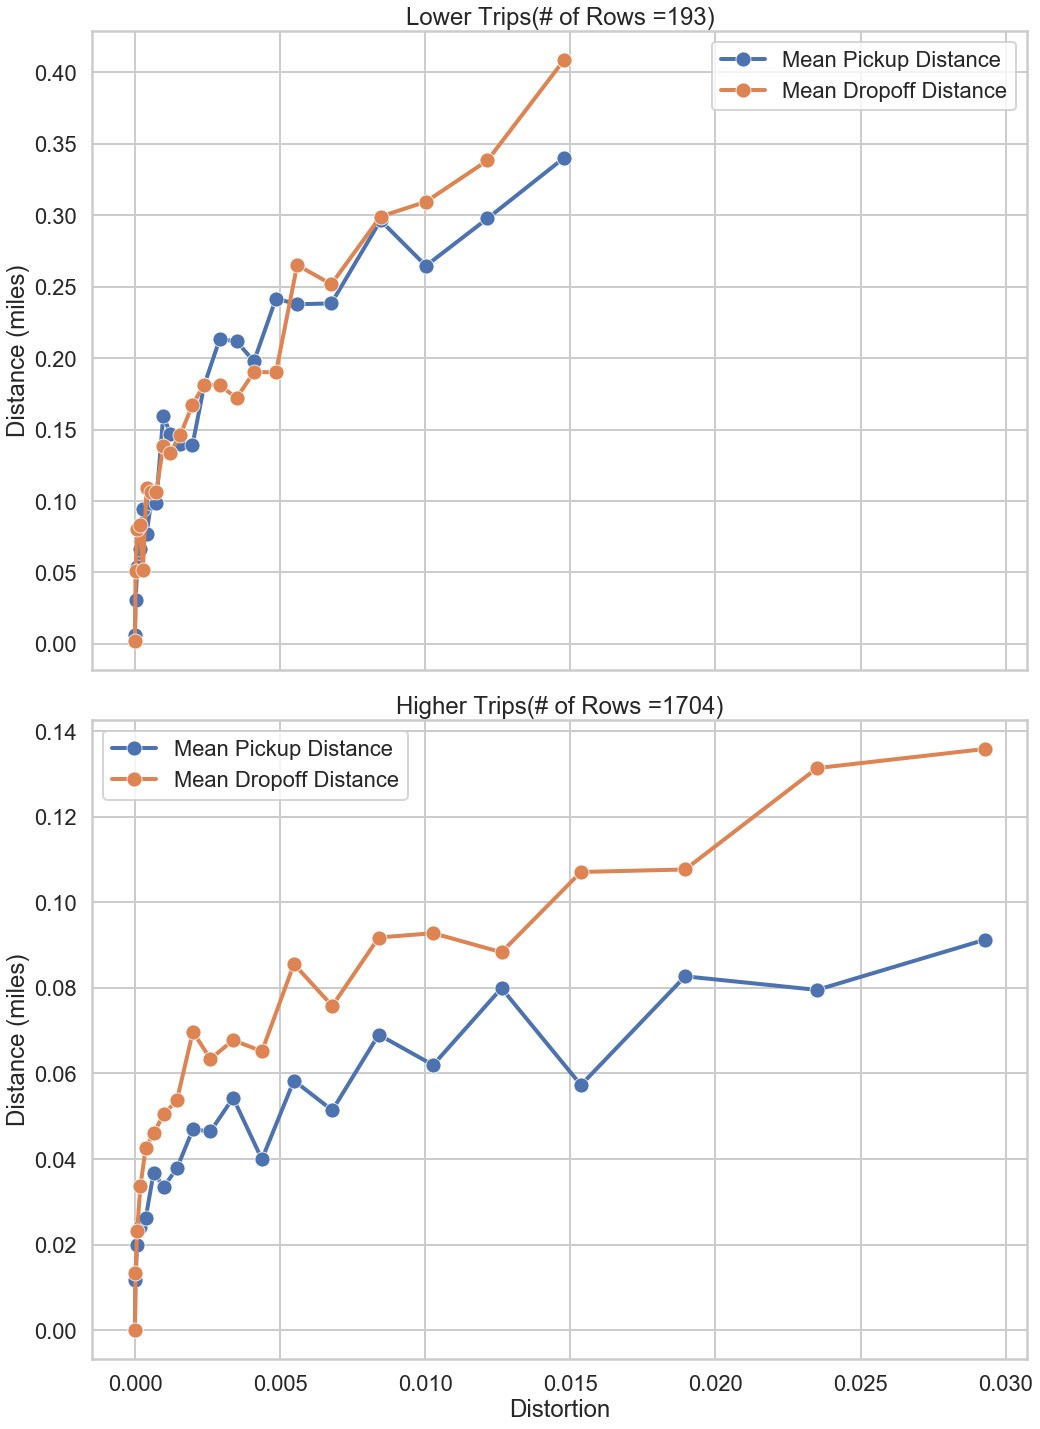

In [25]:
fig, ax = plt.subplots(2,figsize=(15,20), sharex=True)
data_size =[]

for i in range(20,31,10):
    df_train = yc_2016_jun_wk1_proc.loc[(yc_2016_jun_wk1_proc['Date']==trips_grp_by_time_date['Date'][i]) & 
                                     (yc_2016_jun_wk1_proc['Time']==trips_grp_by_time_date['Time'][i])]
    data_size.append(len(df_train))
    feat_list =  ['pickup_latitude' ,'pickup_longitude','dropoff_latitude' , 'dropoff_longitude']

    distortions = []
    pu_dist = []
    do_dist = []

    train = df_train[feat_list].copy()
    step_size = int((len(train)//1 - len(train)//5)//20)
    cluster_range = np.arange(int(len(train)//5), int(len(train)//1),step_size)

    for n in cluster_range:

        kmeans = KMeans(n_clusters=n,n_jobs=-1, random_state=0).fit(train)
        df_train['cluster'] = kmeans.labels_
        
        distortions.append(kmeans.inertia_)
        pu_dist.append(mean_pickup_dropoff_dist(df_train,kmeans)[0])
        do_dist.append(mean_pickup_dropoff_dist(df_train,kmeans)[1])
    sns.lineplot(x=distortions, y =pu_dist, linewidth=4,marker='o', label = 'Mean Pickup Distance', ax = ax[int((i-20)/10)])
    sns.lineplot(x=distortions, y =do_dist, linewidth=4,marker='o', label = 'Mean Dropoff Distance',ax = ax[int((i-20)/10)])

ax[0].set_ylabel('Distance (miles)')
ax[1].set_ylabel('Distance (miles)')
ax[0].title.set_text('Lower Trips(# of Rows ='+ str(data_size[0])+ ')')
ax[1].title.set_text('Higher Trips(# of Rows ='+ str(data_size[1])+ ')')
plt.tight_layout()
plt.xlabel('Distortion')
plt.show()

### Perform Clustering , Summarized with total trips, clusters, trips after clustering

In [26]:
fname='./Data/Pickled Data/Summary_DF.pkl'

for i in range(len(trips_grp_by_time_date)):
    
    df_train = yc_2016_jun_wk1_proc.loc[(yc_2016_jun_wk1_proc['Date']==trips_grp_by_time_date['Date'][i]) & 
                                 (yc_2016_jun_wk1_proc['Time']==trips_grp_by_time_date['Time'][i])]
    
    trips_grp_by_time_date.loc[i, 'Total Trips'] = len(df_train)
    trips_grp_by_time_date.loc[i, 'Total Single Trips'] = len(df_train.loc[(df_train['passenger_count']==1)])
    
    feat_list_m1 =  ['pickup_latitude' ,'pickup_longitude','dropoff_latitude' , 'dropoff_longitude']
    cluster_df_m1, kmeans_model_m1 = kmeans_cluster(df_train,feat_list_m1)
    
    total_passengers,total_trips, total_single_rides = after_cluster_data(cluster_df_m1)
    single_cluster_count,total_cluster_count = get_single_cluster_count(cluster_df_m1)
    
    trips_grp_by_time_date.loc[i,'Total Passengers'] = total_passengers
    trips_grp_by_time_date.loc[i,'Total Trips after Agg Method_1'] = total_trips
    trips_grp_by_time_date.loc[i,'Single Trips after Agg Method_1'] = total_single_rides
    trips_grp_by_time_date.loc[i,'Total Clusters Method_1'] = total_cluster_count
    trips_grp_by_time_date.loc[i,'Single Clusters Method_1'] = single_cluster_count
    trips_grp_by_time_date.loc[i,'Mean Pickup Dist Method_1'] = mean_pickup_dropoff_dist(cluster_df_m1,kmeans_model_m1)[0]
    trips_grp_by_time_date.loc[i,'Mean Dropoff Dist Method_1'] = mean_pickup_dropoff_dist(cluster_df_m1,kmeans_model_m1)[1]
        
    if i==0:
        tic = perf_counter()
        generate_map('Method_1',cluster_df_m1,kmeans_model_m1)
    
    feat_list_m2 =  ['pickup_latitude' ,'pickup_longitude','Bearing Angle' , 'Distance']
    cluster_df_m2, kmeans_model_m2 = kmeans_cluster(df_train,feat_list_m2)
    
    total_passengers,total_trips, total_single_rides = after_cluster_data(cluster_df_m2)
    single_cluster_count,total_cluster_count = get_single_cluster_count(cluster_df_m2)
    
    trips_grp_by_time_date.loc[i,'Total Trips after Agg Method_2'] = total_trips
    trips_grp_by_time_date.loc[i,'Single Trips after Agg Method_2'] = total_single_rides
    trips_grp_by_time_date.loc[i,'Total Clusters Method_2'] = total_cluster_count
    trips_grp_by_time_date.loc[i,'Single Clusters Method_2'] = single_cluster_count
    
    trips_grp_by_time_date.loc[i,'Mean Pickup Dist Method_2'] = mean_pickup_dropoff_dist(cluster_df_m2,kmeans_model_m2)[0]
    if i==0:
        generate_map('Method_2',cluster_df_m2,kmeans_model_m2)
    if (i+1)%50==0:
        
        toc = perf_counter()
        print('Done Rows = ',i+1,' in ', toc-tic, 'seconds')
        trips_grp_by_time_date.to_pickle(fname)
        tic = perf_counter()
        
                               
trips_grp_by_time_date.to_pickle('./Data/Pickled Data/Summary_DF.pkl')
trips_grp_by_time_date.head()

Done Rows =  50  in  171.01309529999997
Done Rows =  100  in  449.87415080000005
Done Rows =  150  in  244.8703527
Done Rows =  200  in  508.83766320000007
Done Rows =  250  in  345.56238259999986
Done Rows =  300  in  388.4881647999998
Done Rows =  350  in  330.5971618999997
Done Rows =  400  in  437.4287648999998
Done Rows =  450  in  323.9331566000001
Done Rows =  500  in  492.81038400000034
Done Rows =  550  in  343.8098380000006
Done Rows =  600  in  440.9431579000002
Done Rows =  650  in  225.03566780000074


Date      Time  Total Trips  Total Single Trips  Total Passengers  \
0  2016-06-06  00:00:00          350               263.0             478.0   
1  2016-06-06  00:15:00          717               550.0             941.0   
2  2016-06-06  00:30:00          696               531.0             931.0   
3  2016-06-06  00:45:00          629               465.0             861.0   
4  2016-06-06  01:00:00          509               387.0             682.0   

   Total Trips after Agg Method_1  Single Trips after Agg Method_1  \
0                           186.0                             40.0   
1                           364.0                             80.0   
2                           364.0                             72.0   
3                           336.0                             77.0   
4                           266.0                             56.0   

   Total Clusters Method_1  Single Clusters Method_1  \
0                    139.0                      47.0   
1                    285.0                      99.0   
2                    278.0                     103.0   
3                    251.0                      94.0   
4                    203.0                      69.0   

   Mean Pickup Dist Method_1  Mean Dropoff Dist Method_1  \
0                   0.249750                    0.199250   
1                   0.168552                    0.155029   
2                   0.148417                    0.107694   
3                   0.164738                    0.135429   
4                   0.156604                    0.164192   

   Total Trips after Agg Method_2  Single Trips after Agg Method_2  \
0                           171.0                             18.0   
1                           368.0                             67.0   
2                           326.0                             46.0   
3                           300.0                             34.0   
4                           249.0                             35.0   

   Total Clusters Method_2  Single Clusters Method_2  \
0                    113.0                      23.0   
1                    285.0                      95.0   
2                    226.0                      61.0   
3                    204.0                      48.0   
4                    165.0                      43.0   

   Mean Pickup Dist Method_2  
0                   0.221357  
1                   0.143941  
2                   0.125649  
3                   0.129651  
4                   0.190667

In [27]:
summary_df = trips_grp_by_time_date.drop(columns = ['Total Clusters Method_1', 
                                                    'Single Clusters Method_1', 
                                                    'Total Clusters Method_2',
                                                   'Single Clusters Method_2'])

summary_df['Method_1 Single Ride Efficiency'] = 100*(summary_df['Total Single Trips'] - 
                                                 summary_df['Single Trips after Agg Method_1']) \
                                                 /summary_df['Total Single Trips']

summary_df['Method_2 Single Ride Efficiency'] = 100*(summary_df['Total Single Trips'] - 
                                                 summary_df['Single Trips after Agg Method_2']) \
                                                 /summary_df['Total Single Trips']

summary_df['Method_1 Overall Efficiency'] = 100*(summary_df['Total Trips'] - 
                                                 summary_df['Total Trips after Agg Method_1']) \
                                                 /summary_df['Total Trips']
summary_df['Method_2 Overall Efficiency'] = 100*(summary_df['Total Trips'] - 
                                                 summary_df['Total Trips after Agg Method_2']) \
                                                 /summary_df['Total Trips']

summary_df['Hour'] = pd.to_datetime(summary_df['Time'],format='%H:%M:%S').dt.hour
summary_df['Day'] = pd.to_datetime(summary_df['Date']).dt.strftime('%A')

summary_df.head()

Date      Time  Total Trips  Total Single Trips  Total Passengers  \
0  2016-06-06  00:00:00          350               263.0             478.0   
1  2016-06-06  00:15:00          717               550.0             941.0   
2  2016-06-06  00:30:00          696               531.0             931.0   
3  2016-06-06  00:45:00          629               465.0             861.0   
4  2016-06-06  01:00:00          509               387.0             682.0   

   Total Trips after Agg Method_1  Single Trips after Agg Method_1  \
0                           186.0                             40.0   
1                           364.0                             80.0   
2                           364.0                             72.0   
3                           336.0                             77.0   
4                           266.0                             56.0   

   Mean Pickup Dist Method_1  Mean Dropoff Dist Method_1  \
0                   0.249750                    0.199250   
1                   0.168552                    0.155029   
2                   0.148417                    0.107694   
3                   0.164738                    0.135429   
4                   0.156604                    0.164192   

   Total Trips after Agg Method_2  Single Trips after Agg Method_2  \
0                           171.0                             18.0   
1                           368.0                             67.0   
2                           326.0                             46.0   
3                           300.0                             34.0   
4                           249.0                             35.0   

   Mean Pickup Dist Method_2  Method_1 Single Ride Efficiency  \
0                   0.221357                        84.790875   
1                   0.143941                        85.454545   
2                   0.125649                        86.440678   
3                   0.129651                        83.440860   
4                   0.190667                        85.529716   

   Method_2 Single Ride Efficiency  Method_1 Overall Efficiency  \
0                        93.155894                    46.857143   
1                        87.818182                    49.232915   
2                        91.337100                    47.701149   
3                        92.688172                    46.581876   
4                        90.956072                    47.740668   

   Method_2 Overall Efficiency  Hour     Day  
0                    51.142857     0  Monday  
1                    48.675035     0  Monday  
2                    53.160920     0  Monday  
3                    52.305246     0  Monday  
4                    51.080550     1  Monday

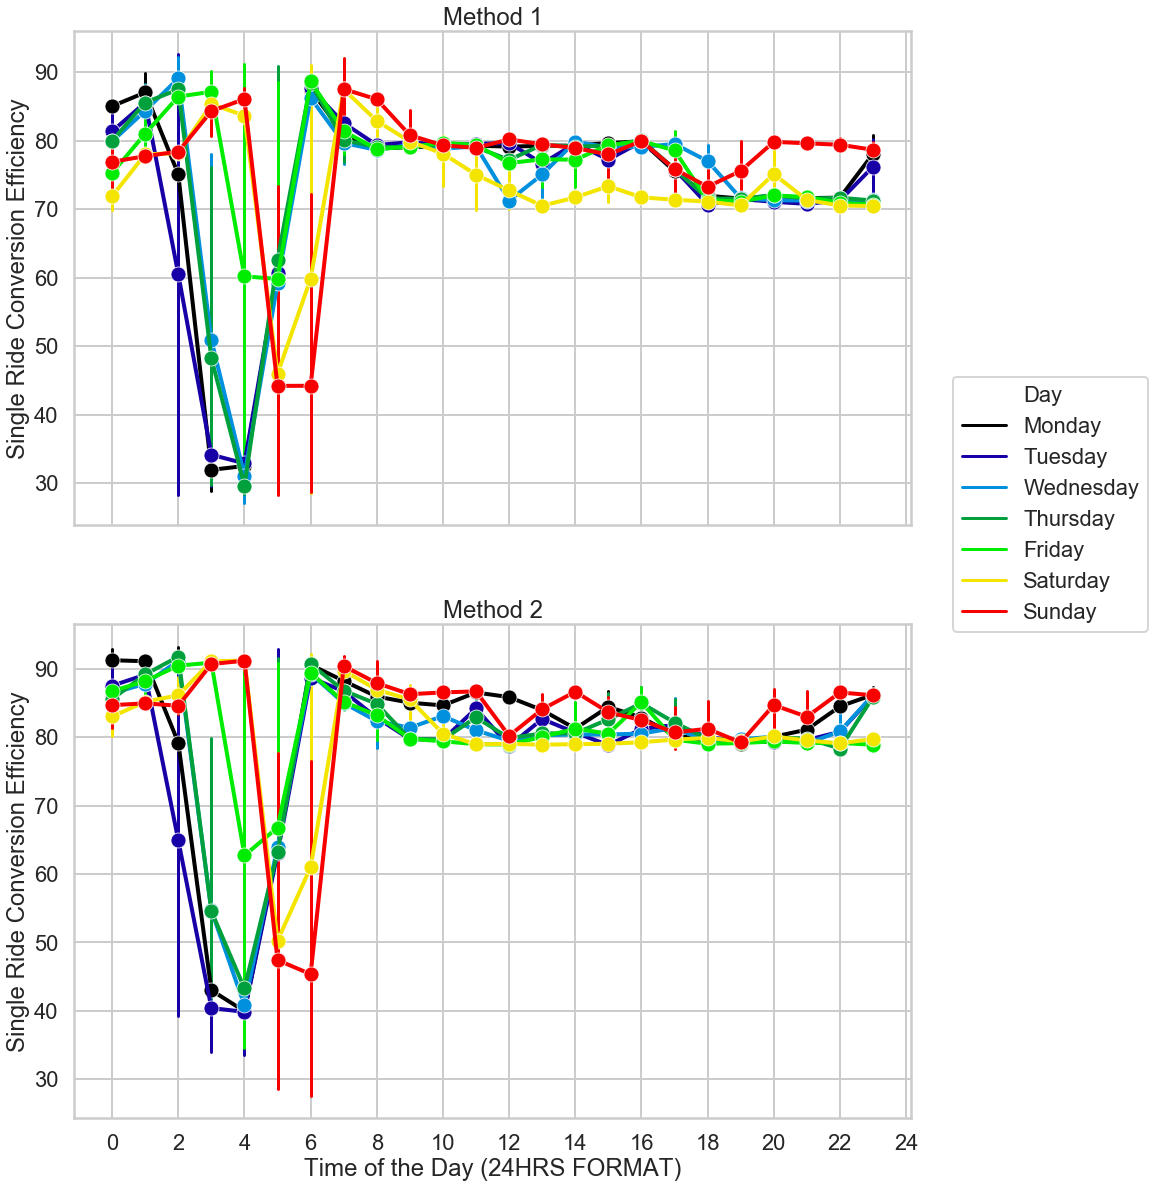

In [28]:
fig, ax = plt.subplots(2,figsize=(15,20), sharex=True)

colors = cm.nipy_spectral(np.linspace(0, 1, summary_df['Day'].nunique()+1))

plot_1 = sns.lineplot(x='Hour', y = 'Method_1 Single Ride Efficiency',palette=colors, linewidth=4,
                      hue='Day' ,marker='o', data= summary_df, ax=ax[0], legend=False,err_style="bars")
plot_2 = sns.lineplot(x='Hour', y = 'Method_2 Single Ride Efficiency',palette=colors, linewidth=4,
                      hue='Day' ,marker='o', data= summary_df,ax=ax[1],err_style="bars")

plt.xlabel(xlabel = 'Time of the Day (24HRS FORMAT)')
plt.legend(bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0.)
plot_1.xaxis.set_major_locator(MultipleLocator(2))

ax[0].set_ylabel('Single Ride Conversion Efficiency')
ax[1].set_ylabel('Single Ride Conversion Efficiency')
ax[0].title.set_text('Method 1')
ax[1].title.set_text('Method 2')

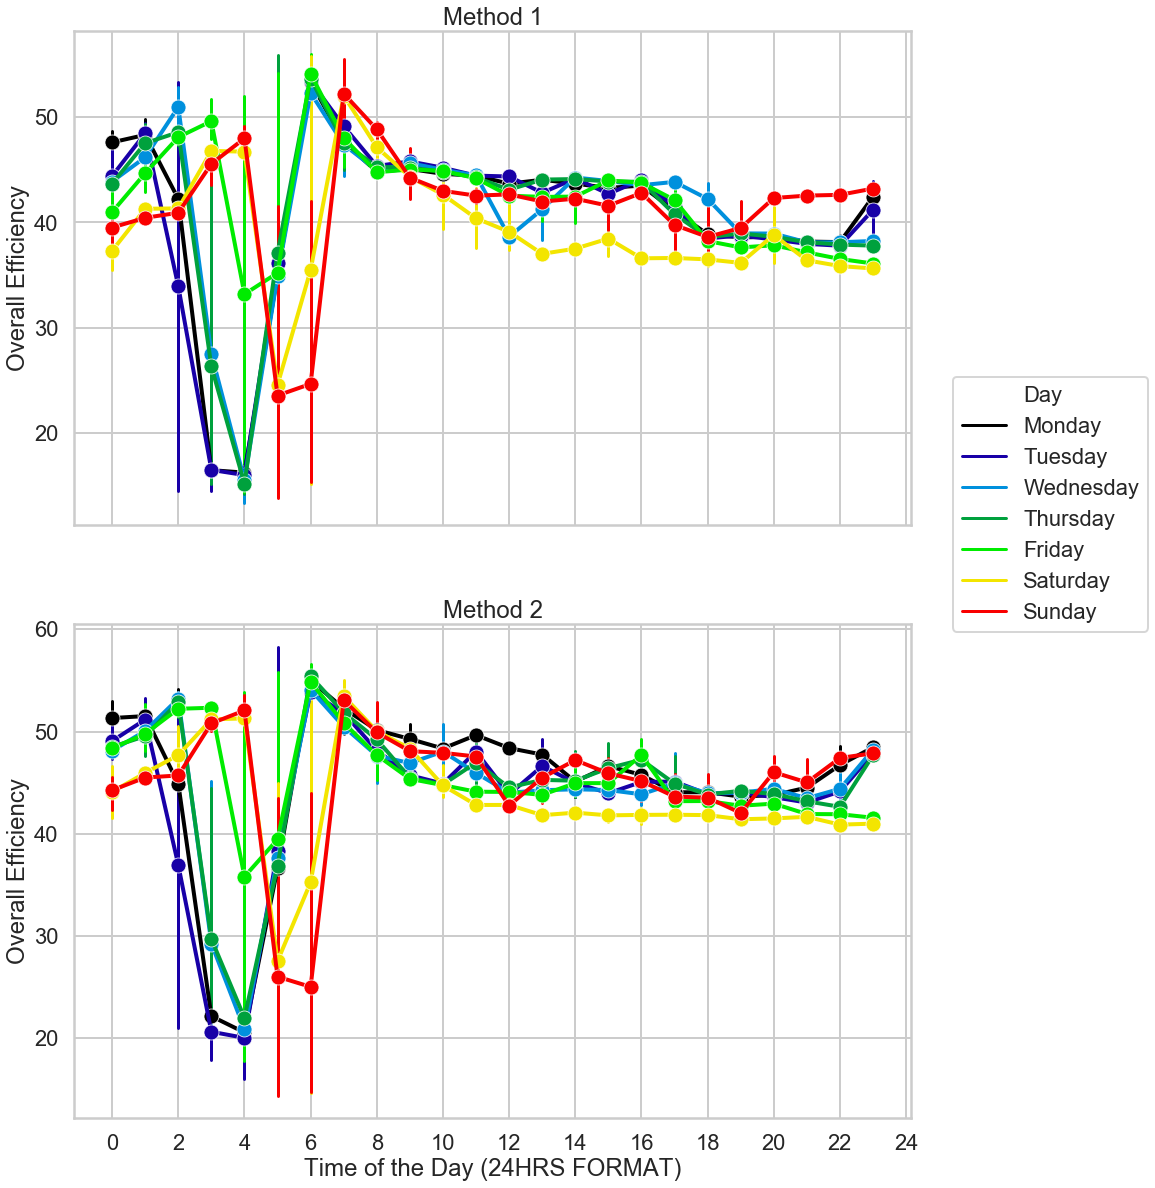

In [29]:
fig, ax = plt.subplots(2,figsize=(15,20), sharex=True)

colors = cm.nipy_spectral(np.linspace(0, 1, summary_df['Day'].nunique()+1))

plot_1 = sns.lineplot(x='Hour', y = 'Method_1 Overall Efficiency',palette=colors, linewidth=4,
                      hue='Day' ,marker='o', data= summary_df, ax=ax[0], legend=False,err_style="bars")
plot_2 = sns.lineplot(x='Hour', y = 'Method_2 Overall Efficiency',palette=colors, linewidth=4,
                      hue='Day' ,marker='o', data= summary_df,ax=ax[1],err_style="bars")

plt.xlabel(xlabel = 'Time of the Day (24HRS FORMAT)')
plt.legend(bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0.)
plot_1.xaxis.set_major_locator(MultipleLocator(2))

ax[0].set_ylabel('Overall Efficiency')
ax[1].set_ylabel('Overall Efficiency')
ax[0].title.set_text('Method 1')
ax[1].title.set_text('Method 2')

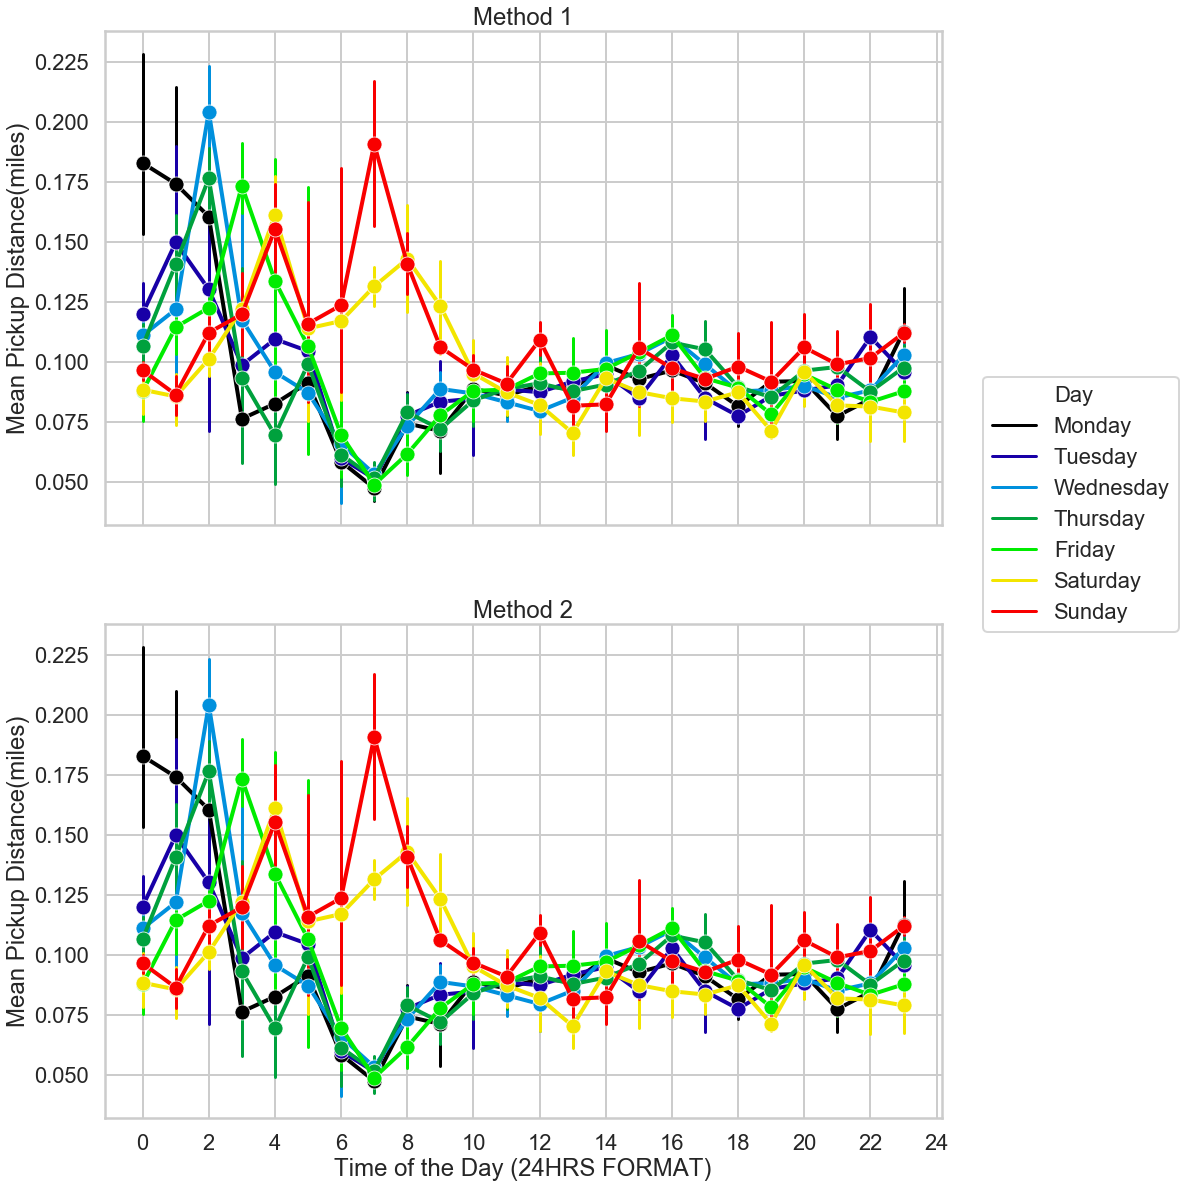

In [30]:
fig, ax = plt.subplots(2,figsize=(15,20), sharex=True)

colors = cm.nipy_spectral(np.linspace(0, 1, summary_df['Day'].nunique()+1))

plot_1 = sns.lineplot(x='Hour', y = 'Mean Pickup Dist Method_1',palette=colors, linewidth=4,
                      hue='Day' ,marker='o', data= summary_df, ax=ax[0], legend=False,err_style="bars", label= 'Method 1')


plot_2 = sns.lineplot(x='Hour', y = 'Mean Pickup Dist Method_1',palette=colors, linewidth=4,
                      hue='Day' ,marker='o', data= summary_df,ax=ax[1],err_style="bars")

plt.xlabel(xlabel = 'Time of the Day (24HRS FORMAT)')
plt.legend(bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0.)
plot_1.xaxis.set_major_locator(MultipleLocator(2))
ax[0].set_ylabel('Mean Pickup Distance(miles)')
ax[1].set_ylabel('Mean Pickup Distance(miles)')
ax[0].title.set_text('Method 1')
ax[1].title.set_text('Method 2')


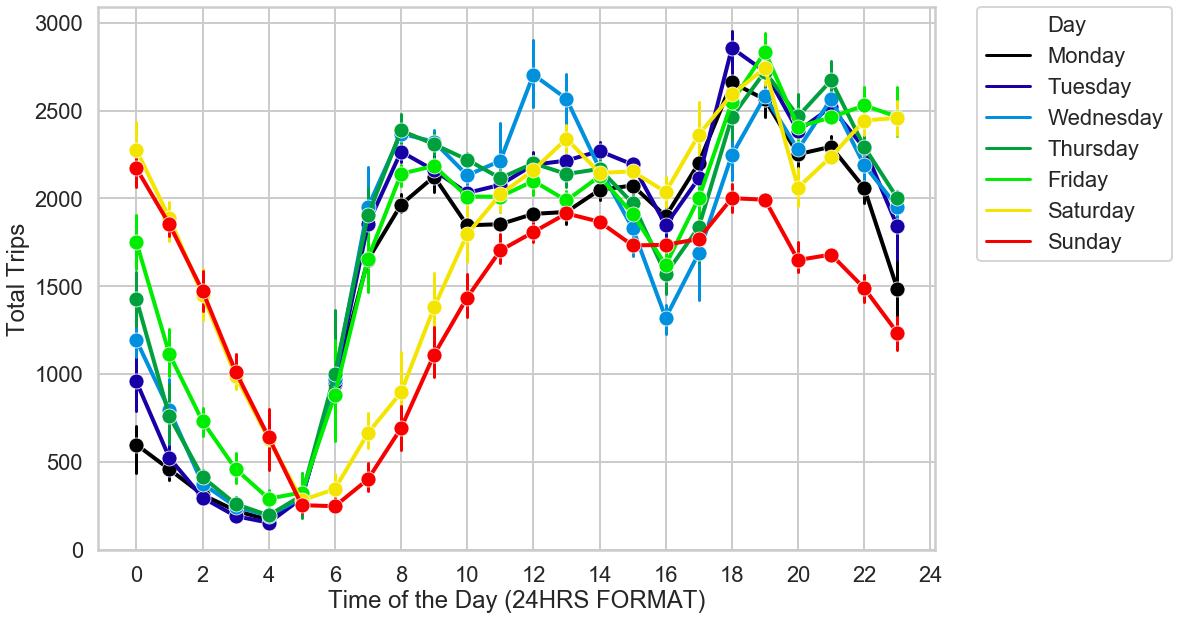

In [31]:
fig = plt.figure(figsize=(15,10))

colors = cm.nipy_spectral(np.linspace(0, 1, summary_df['Day'].nunique()+1))

plot_1 = sns.lineplot(x='Hour', y = 'Total Trips',palette=colors, linewidth=4,
                      hue='Day' ,marker='o', data= summary_df,err_style="bars")


plt.xlabel(xlabel = 'Time of the Day (24HRS FORMAT)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plot_1.xaxis.set_major_locator(MultipleLocator(2))

Text(0, 0.5, 'Single Ride Conversion Efficiency (%)')

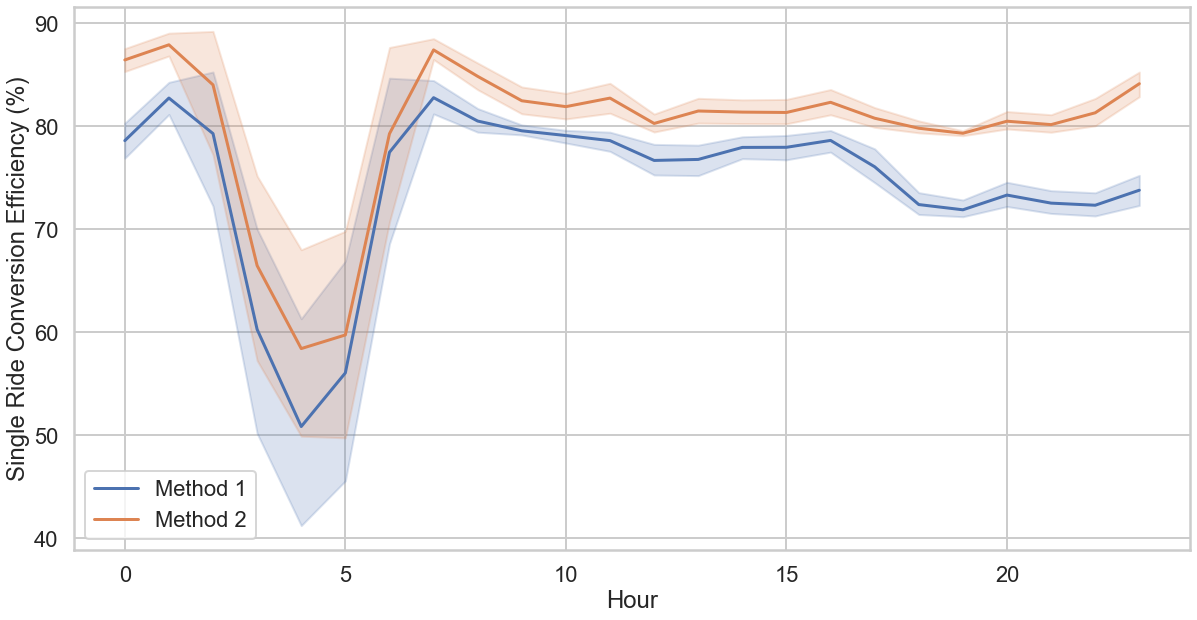

In [32]:
fig = plt.figure(figsize=(20,10))

sns.lineplot(x='Hour', y = 'Method_1 Single Ride Efficiency',  data= summary_df,
             label = 'Method 1')
sns.lineplot(x='Hour', y = 'Method_2 Single Ride Efficiency', data= summary_df,
            label = 'Method 2')
plt.ylabel('Single Ride Conversion Efficiency (%)')

Text(0, 0.5, 'Overall Ride Conversion Efficiency (%)')

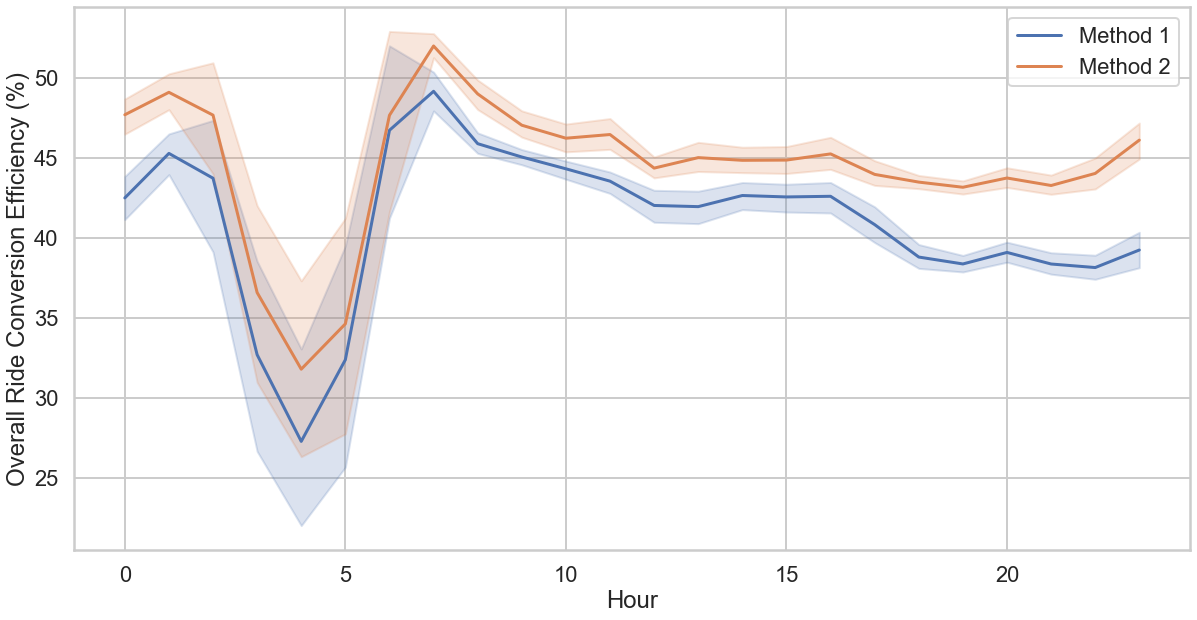

In [33]:
fig = plt.figure(figsize=(20,10))

sns.lineplot(x='Hour', y = 'Method_1 Overall Efficiency',  data= summary_df,
             label = 'Method 1')
sns.lineplot(x='Hour', y = 'Method_2 Overall Efficiency', data= summary_df,
            label = 'Method 2')
plt.ylabel('Overall Ride Conversion Efficiency (%)')

Text(0, 0.5, 'Ratio (# of Clusters/Total Trips)')

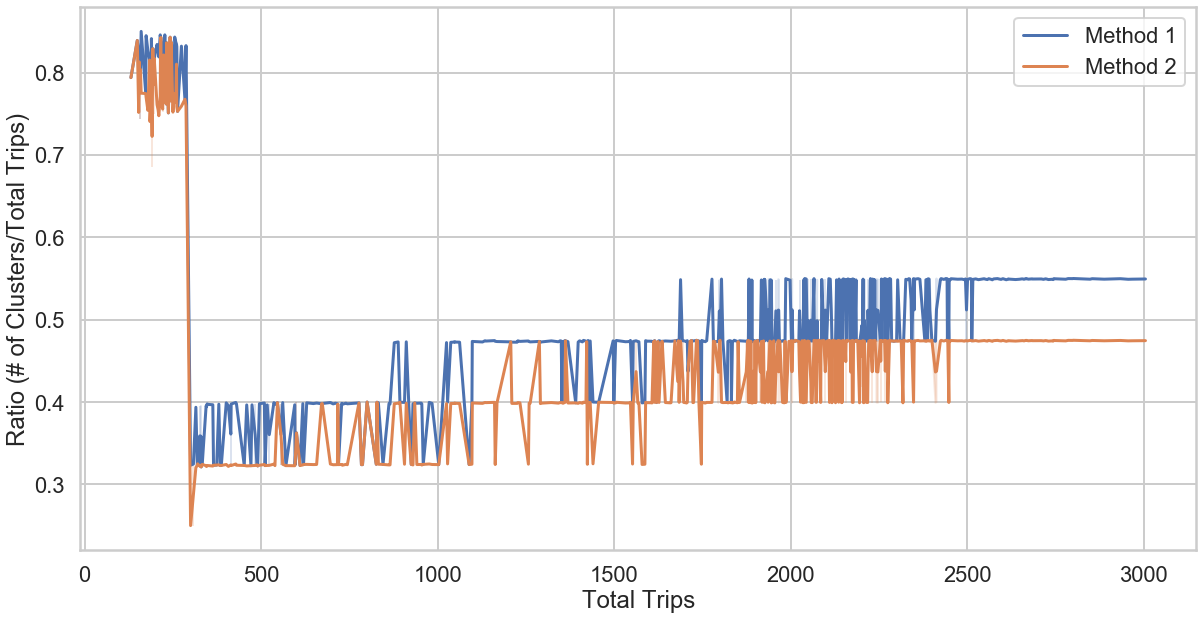

In [34]:
fig = plt.figure(figsize=(20,10))

sns.lineplot(x='Total Trips', 
             y = ( trips_grp_by_time_date['Total Clusters Method_1'])/trips_grp_by_time_date['Total Trips'],
             data= trips_grp_by_time_date,
             label = 'Method 1')
sns.lineplot(x='Total Trips', 
             y = (trips_grp_by_time_date['Total Clusters Method_2'])/trips_grp_by_time_date['Total Trips'],
             data= trips_grp_by_time_date,
             label = 'Method 2')
plt.ylabel('Ratio (# of Clusters/Total Trips)')

Text(0, 0.5, 'Single Ride Conversion Efficiency (%)')

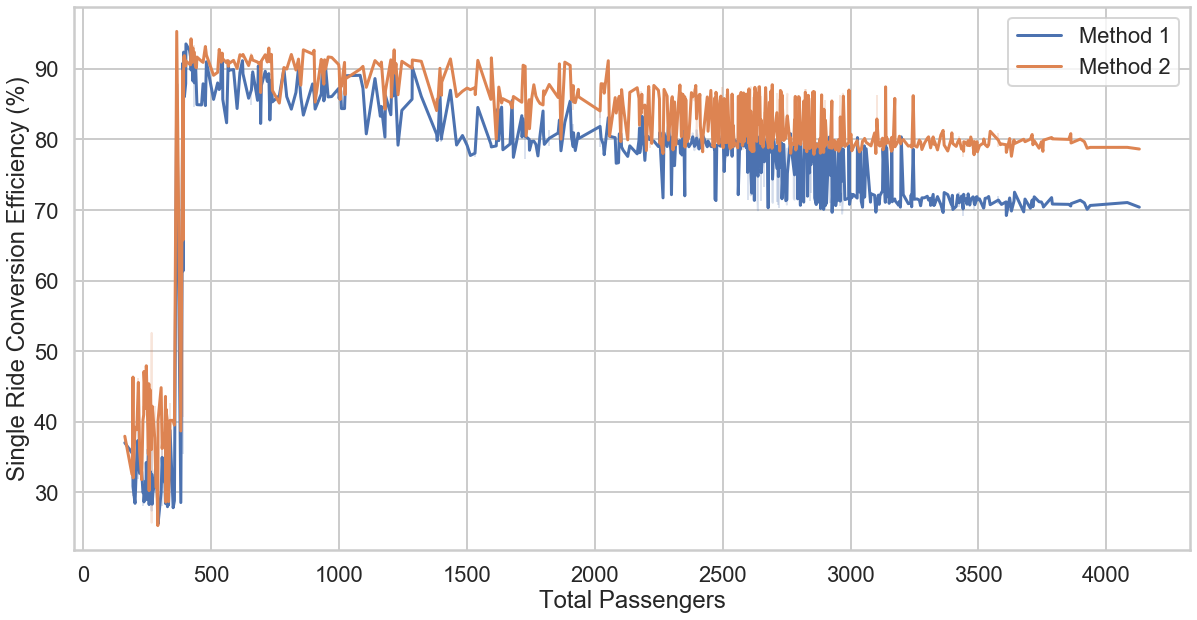

In [35]:
fig = plt.figure(figsize=(20,10))

sns.lineplot(x='Total Passengers', y = 'Method_1 Single Ride Efficiency',  data= summary_df,
             label = 'Method 1')
sns.lineplot(x='Total Passengers', y = 'Method_2 Single Ride Efficiency', data= summary_df,
            label = 'Method 2')
plt.ylabel('Single Ride Conversion Efficiency (%)')

Text(0, 0.5, 'Single Ride Efficiency (%)')

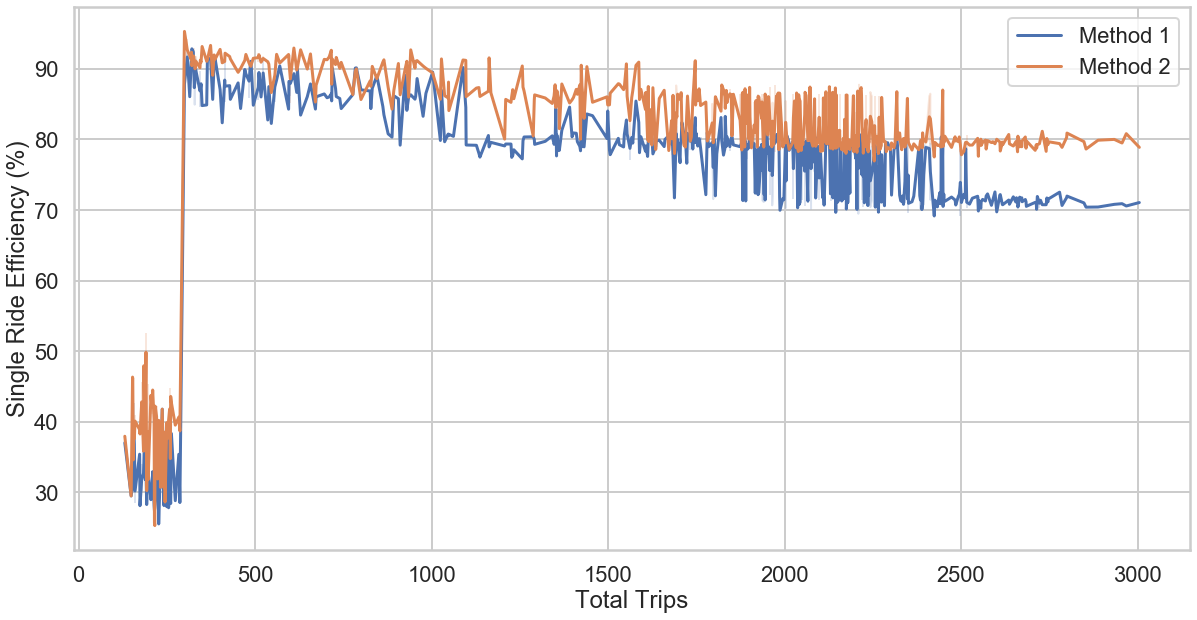

In [36]:
fig = plt.figure(figsize=(20,10))
sns.lineplot(x='Total Trips', y = 'Method_1 Single Ride Efficiency',  data= summary_df,
             label = 'Method 1')
sns.lineplot(x='Total Trips', y = 'Method_2 Single Ride Efficiency', data= summary_df,
            label = 'Method 2')
plt.ylabel('Single Ride Efficiency (%)')


Text(0, 0.5, 'Overall Efficiency (%)')

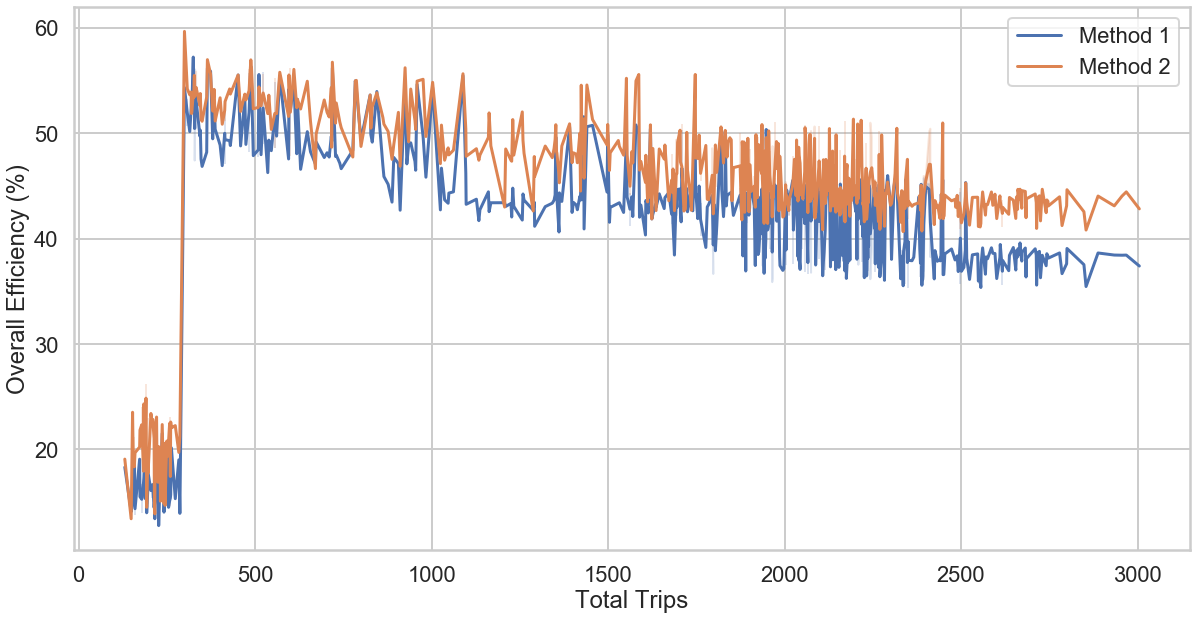

In [37]:
fig = plt.figure(figsize=(20,10))
sns.lineplot(x='Total Trips', y = 'Method_1 Overall Efficiency',  data= summary_df,
             label = 'Method 1')
sns.lineplot(x='Total Trips', y = 'Method_2 Overall Efficiency', data= summary_df,
            label = 'Method 2')

plt.ylabel('Overall Efficiency (%)')

Text(0, 0.5, 'Mean Pickup Distance (miles)')

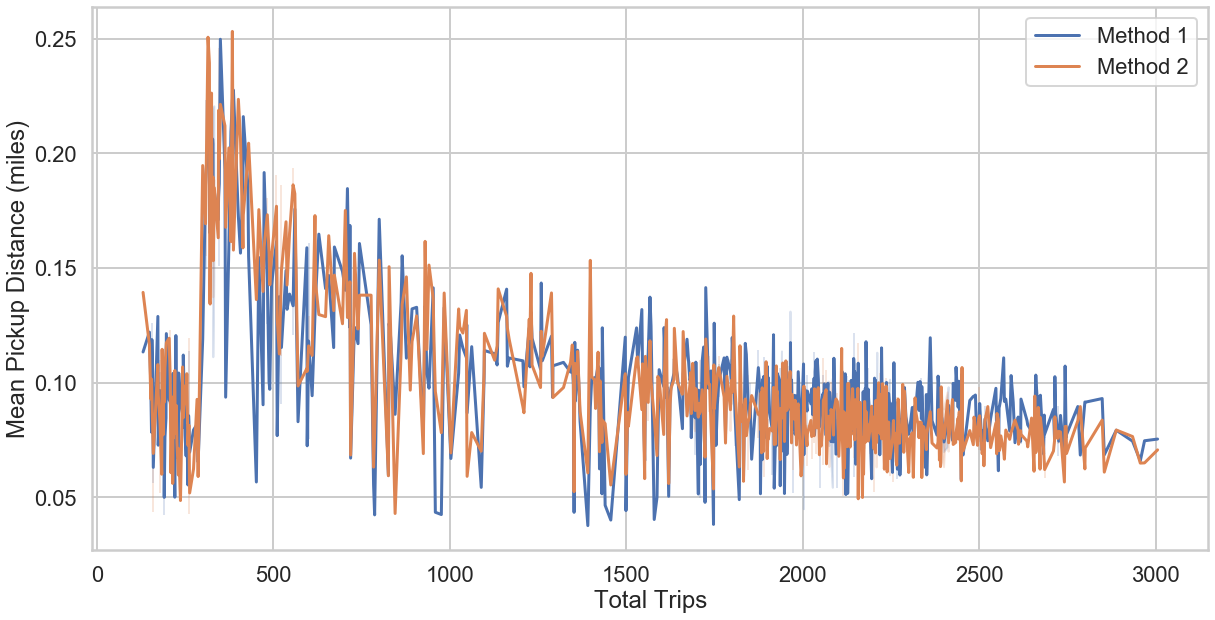

In [38]:
fig = plt.figure(figsize=(20,10))
sns.lineplot(x='Total Trips', y = 'Mean Pickup Dist Method_1',  data= summary_df,
             label = 'Method 1')
sns.lineplot(x='Total Trips', y = 'Mean Pickup Dist Method_2', data= summary_df,
            label = 'Method 2')
plt.ylabel('Mean Pickup Distance (miles)')

In [39]:
yc_2016_jun_wk1_proc_neigh['Hour'] = pd.to_datetime(yc_2016_jun_wk1_proc_neigh['Time'],format='%H:%M:%S').dt.hour

trips_grp_by_neigh_time = yc_2016_jun_wk1_proc_neigh.groupby(["Neighborhood","Hour"]).size()
trips_grp_by_neigh_time= trips_grp_by_neigh_time.reset_index()
trips_grp_by_neigh_time = trips_grp_by_neigh_time.rename(columns={0:'Total Trips'})
trips_grp_by_neigh_time = trips_grp_by_neigh_time.loc[trips_grp_by_neigh_time['Total Trips']>5]
trips_grp_by_neigh_time = trips_grp_by_neigh_time.reset_index(drop=True)
trips_grp_by_neigh_time

Neighborhood  Hour  Total Trips
0    Central Harlem North-Polo Grounds     0           81
1    Central Harlem North-Polo Grounds     1           65
2    Central Harlem North-Polo Grounds     2           49
3    Central Harlem North-Polo Grounds     3           42
4    Central Harlem North-Polo Grounds     4           45
..                                 ...   ...          ...
448                       West Village    19         6748
449                       West Village    20         6549
450                       West Village    21         7500
451                       West Village    22         7055
452                       West Village    23         7118

[453 rows x 3 columns]

In [40]:
size = []
distortions = []
dist = []
for i in range(1,100,2):
    df_train = yc_2016_jun_wk1_proc_neigh.loc[(yc_2016_jun_wk1_proc_neigh['Neighborhood']==trips_grp_by_neigh_time['Neighborhood'][270])
                                  & 
                         (yc_2016_jun_wk1_proc_neigh['Hour']==trips_grp_by_neigh_time['Hour'][270])]
    df_train = df_train.sample(frac = 0.25* 0.01*i)
    train = df_train[feat_list].copy()
    n = int(len(df_train)/10)
    
    kmeans = KMeans(n_clusters=n,n_jobs=-1, random_state=0).fit(train)
    df_train['cluster'] = kmeans.labels_
    distortions.append(kmeans.inertia_)
    size.append(len(df_train))
    pu, do = mean_pickup_dropoff_dist(df_train,kmeans)
    dist.append((pu+do)/2)


In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
X = np.column_stack([dist, size])
a = np.ones((len(dist),1))
#X = np.hstack((a,X))
model1 = LinearRegression()
model2 = RandomForestRegressor()
model1.fit(X,distortions)
model2.fit(X,distortions)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [42]:
x_pred = np.array([0.1, 8000])
print(model1.predict(x_pred.reshape(1,-1))[0])
print(model2.predict(x_pred.reshape(1,-1))[0])

0.04323590882650177
0.023382678447712687


In [43]:

def kmeans_cluster_threshold(df_train,feat_list):
    
    train = df_train[feat_list].copy()
    int(np.ceil(np.ceil(12 - 12/50)/20))
    step_size = int(np.ceil((len(train) - len(train)/50)/20))
    cluster_range = np.arange(int(np.ceil(len(train)/50)), len(train),step_size)
    if len(train)<500:
        threshold = 0.0005
    else:
        x_pred = np.array([0.1, len(train)])
        threshold = model1.predict(x_pred.reshape(1,-1))[0]
    
    for i in cluster_range:
        kmeans = KMeans(n_clusters=i,n_jobs=-1, random_state=0).fit(train)
        if kmeans.inertia_ < threshold:
            break
    df_train['cluster'] = kmeans.labels_
    return df_train, kmeans

In [44]:
fname='./Data/Pickled Data/Summary_DF_loc_hour.pkl'

for i in range(len(trips_grp_by_neigh_time)):
    
    df_train = yc_2016_jun_wk1_proc_neigh.loc[(yc_2016_jun_wk1_proc_neigh['Neighborhood']==trips_grp_by_neigh_time['Neighborhood'][i]) & 
                                 (yc_2016_jun_wk1_proc_neigh['Hour']==trips_grp_by_neigh_time['Hour'][i])]
    
    trips_grp_by_neigh_time.loc[i, 'Total Trips'] = len(df_train)
    trips_grp_by_neigh_time.loc[i, 'Total Single Trips'] = len(df_train.loc[(df_train['passenger_count']==1)])
    
    feat_list_m1 =  ['pickup_latitude' ,'pickup_longitude','dropoff_latitude' , 'dropoff_longitude']
    cluster_df_m1, kmeans_model_m1 = kmeans_cluster_threshold(df_train,feat_list_m1)
    
    total_passengers,total_trips, total_single_rides = after_cluster_data(cluster_df_m1)
    single_cluster_count,total_cluster_count = get_single_cluster_count(cluster_df_m1)
    
    trips_grp_by_neigh_time.loc[i,'Total Passengers'] = total_passengers
    trips_grp_by_neigh_time.loc[i,'Total Trips Method_1'] = total_trips
    trips_grp_by_neigh_time.loc[i,'Single Trips Method_1'] = total_single_rides
    trips_grp_by_neigh_time.loc[i,'Total Clusters Method_1'] = total_cluster_count
    trips_grp_by_neigh_time.loc[i,'Single Clusters Method_1'] = single_cluster_count
    trips_grp_by_neigh_time.loc[i,'Mean Pickup Dist Method_1'] = mean_pickup_dropoff_dist(cluster_df_m1,kmeans_model_m1)[0]
    trips_grp_by_neigh_time.loc[i,'Mean Dropoff Dist Method_1'] = mean_pickup_dropoff_dist(cluster_df_m1,kmeans_model_m1)[1]
        
    if i==0:
        tic = perf_counter()
    
    feat_list_m2 =  ['pickup_latitude' ,'pickup_longitude','Bearing Angle' , 'Distance']
    cluster_df_m2, kmeans_model_m2 = kmeans_cluster_threshold(df_train,feat_list_m2)
    
    total_passengers,total_trips, total_single_rides = after_cluster_data(cluster_df_m2)
    single_cluster_count,total_cluster_count = get_single_cluster_count(cluster_df_m2)
    
    trips_grp_by_neigh_time.loc[i,'Total Trips Method_2'] = total_trips
    trips_grp_by_neigh_time.loc[i,'Single Trips Method_2'] = total_single_rides
    trips_grp_by_neigh_time.loc[i,'Total Clusters Method_2'] = total_cluster_count
    trips_grp_by_neigh_time.loc[i,'Single Clusters Method_2'] = single_cluster_count
    
    trips_grp_by_neigh_time.loc[i,'Mean Pickup Dist Method_2'] = mean_pickup_dropoff_dist(cluster_df_m2,kmeans_model_m2)[0]
    if i==0:
        generate_map('Method_2',cluster_df_m2,kmeans_model_m2)
    if (i+1)%50==0:
        
        toc = perf_counter()
        print('Processed ',i+1,'Rows in ', toc-tic, 'seconds')
        trips_grp_by_neigh_time.to_pickle(fname)
        tic = perf_counter()
        
                               
trips_grp_by_neigh_time.to_pickle(fname)
trips_grp_by_neigh_time.head()

Processed  50 Rows in  44.94453629999953 seconds
Processed  100 Rows in  85.61634390000017 seconds
Processed  150 Rows in  28.087913200000003 seconds
Processed  200 Rows in  109.15983529999994 seconds
Processed  250 Rows in  462.8062411000001 seconds
Processed  300 Rows in  1305.2365223000006 seconds
Processed  350 Rows in  85.40846739999961 seconds
Processed  400 Rows in  157.8488540999997 seconds
Processed  450 Rows in  132.7522871000001 seconds


Neighborhood  Hour  Total Trips  Total Single Trips  \
0  Central Harlem North-Polo Grounds     0           81                59.0   
1  Central Harlem North-Polo Grounds     1           65                50.0   
2  Central Harlem North-Polo Grounds     2           49                40.0   
3  Central Harlem North-Polo Grounds     3           42                32.0   
4  Central Harlem North-Polo Grounds     4           45                36.0   

   Total Passengers  Total Trips Method_1  Single Trips Method_1  \
0             110.0                  46.0                   11.0   
1              86.0                  38.0                    9.0   
2              65.0                  29.0                   11.0   
3              57.0                  24.0                    7.0   
4              55.0                  24.0                    6.0   

   Total Clusters Method_1  Single Clusters Method_1  \
0                     42.0                      17.0   
1                     34.0                      14.0   
2                     25.0                      12.0   
3                     19.0                       7.0   
4                     22.0                       7.0   

   Mean Pickup Dist Method_1  Mean Dropoff Dist Method_1  \
0                   0.089800                    0.106333   
1                   0.145000                    0.147333   
2                   0.136933                    0.123200   
3                   0.129400                    0.163967   
4                   0.117333                    0.136667   

   Total Trips Method_2  Single Trips Method_2  Total Clusters Method_2  \
0                  44.0                   12.0                     38.0   
1                  39.0                   11.0                     34.0   
2                  28.0                    9.0                     25.0   
3                  25.0                    7.0                     22.0   
4                  27.0                    9.0                     25.0   

   Single Clusters Method_2  Mean Pickup Dist Method_2  
0                      17.0                   0.104786  
1                      14.0                   0.111933  
2                      12.0                   0.121733  
3                      10.0                   0.162000  
4                      13.0                   0.160000

In [45]:
summary_df_loc = trips_grp_by_neigh_time.drop(columns = ['Total Clusters Method_1', 
                                                    'Single Clusters Method_1', 
                                                    'Total Clusters Method_2',
                                                   'Single Clusters Method_2'])

summary_df_loc['Method_1 Single Ride Efficiency'] = 100*(summary_df_loc['Total Single Trips'] - 
                                                 summary_df_loc['Single Trips Method_1']) \
                                                 /summary_df_loc['Total Single Trips']

summary_df_loc['Method_2 Single Ride Efficiency'] = 100*(summary_df_loc['Total Single Trips'] - 
                                                 summary_df_loc['Single Trips Method_2']) \
                                                 /summary_df_loc['Total Single Trips']

summary_df_loc['Method_1 Overall Efficiency'] = 100*(summary_df_loc['Total Trips'] - 
                                                 summary_df_loc['Total Trips Method_1']) \
                                                 /summary_df_loc['Total Trips']
summary_df_loc['Method_2 Overall Efficiency'] = 100*(summary_df_loc['Total Trips'] - 
                                                 summary_df_loc['Total Trips Method_2']) \
                                                 /summary_df_loc['Total Trips']

summary_df_loc.head()

Neighborhood  Hour  Total Trips  Total Single Trips  \
0  Central Harlem North-Polo Grounds     0           81                59.0   
1  Central Harlem North-Polo Grounds     1           65                50.0   
2  Central Harlem North-Polo Grounds     2           49                40.0   
3  Central Harlem North-Polo Grounds     3           42                32.0   
4  Central Harlem North-Polo Grounds     4           45                36.0   

   Total Passengers  Total Trips Method_1  Single Trips Method_1  \
0             110.0                  46.0                   11.0   
1              86.0                  38.0                    9.0   
2              65.0                  29.0                   11.0   
3              57.0                  24.0                    7.0   
4              55.0                  24.0                    6.0   

   Mean Pickup Dist Method_1  Mean Dropoff Dist Method_1  \
0                   0.089800                    0.106333   
1                   0.145000                    0.147333   
2                   0.136933                    0.123200   
3                   0.129400                    0.163967   
4                   0.117333                    0.136667   

   Total Trips Method_2  Single Trips Method_2  Mean Pickup Dist Method_2  \
0                  44.0                   12.0                   0.104786   
1                  39.0                   11.0                   0.111933   
2                  28.0                    9.0                   0.121733   
3                  25.0                    7.0                   0.162000   
4                  27.0                    9.0                   0.160000   

   Method_1 Single Ride Efficiency  Method_2 Single Ride Efficiency  \
0                        81.355932                        79.661017   
1                        82.000000                        78.000000   
2                        72.500000                        77.500000   
3                        78.125000                        78.125000   
4                        83.333333                        75.000000   

   Method_1 Overall Efficiency  Method_2 Overall Efficiency  
0                    43.209877                    45.679012  
1                    41.538462                    40.000000  
2                    40.816327                    42.857143  
3                    42.857143                    40.476190  
4                    46.666667                    40.000000

Text(0, 0.5, 'Overall Ride Conversion Efficiency (%)')

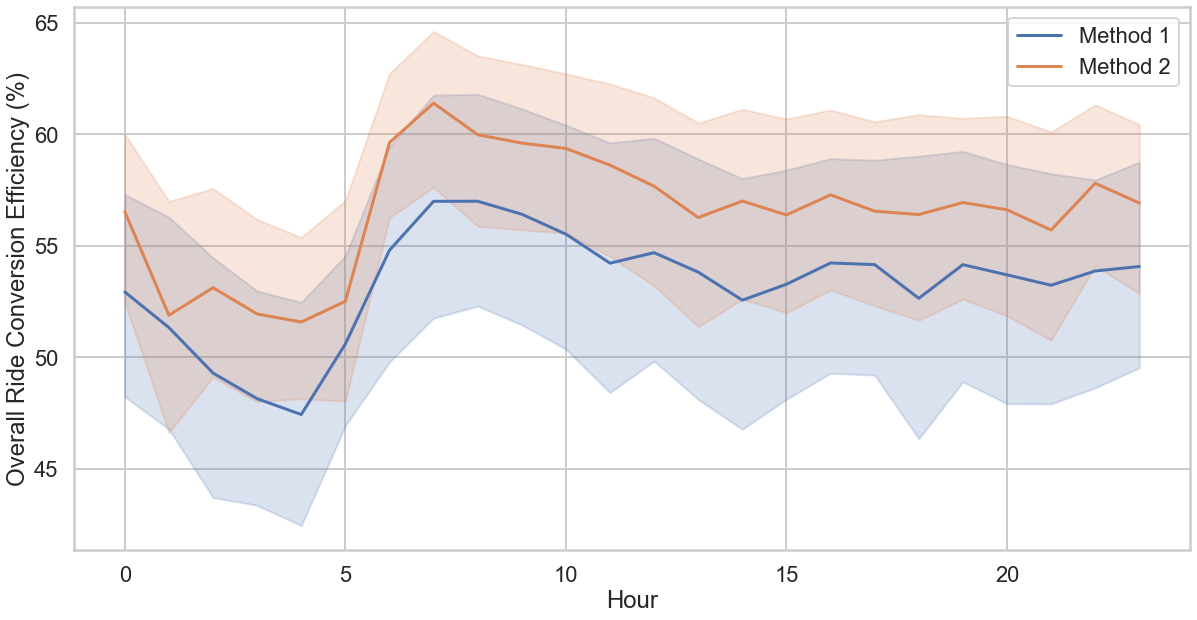

In [46]:
fig = plt.figure(figsize=(20,10))

sns.lineplot(x='Hour', y = 'Method_1 Overall Efficiency',  data= summary_df_loc,
             label = 'Method 1')
sns.lineplot(x='Hour', y = 'Method_2 Overall Efficiency', data= summary_df_loc,
            label = 'Method 2')
plt.ylabel('Overall Ride Conversion Efficiency (%)')

Text(0, 0.5, 'Single Ride Conversion Efficiency (%)')

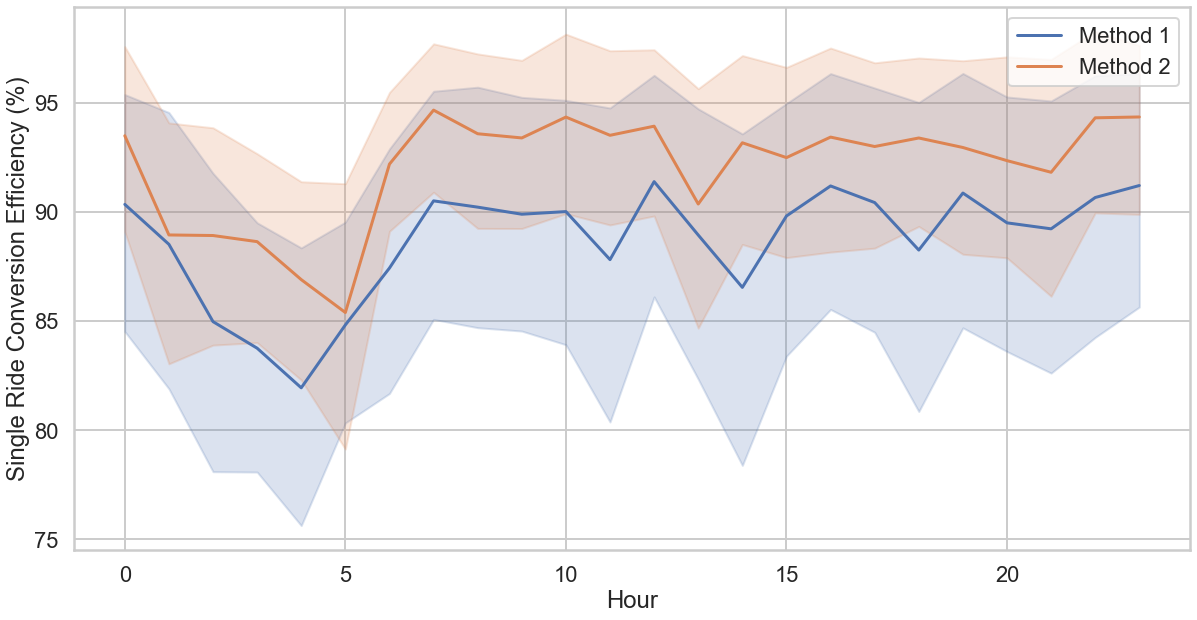

In [47]:
fig = plt.figure(figsize=(20,10))

sns.lineplot(x='Hour', y = 'Method_1 Single Ride Efficiency',  data= summary_df_loc,
             label = 'Method 1')
sns.lineplot(x='Hour', y = 'Method_2 Single Ride Efficiency', data= summary_df_loc,
            label = 'Method 2')
plt.ylabel('Single Ride Conversion Efficiency (%)')

Text(0, 0.5, 'Mean Pickup Distance(miles)')

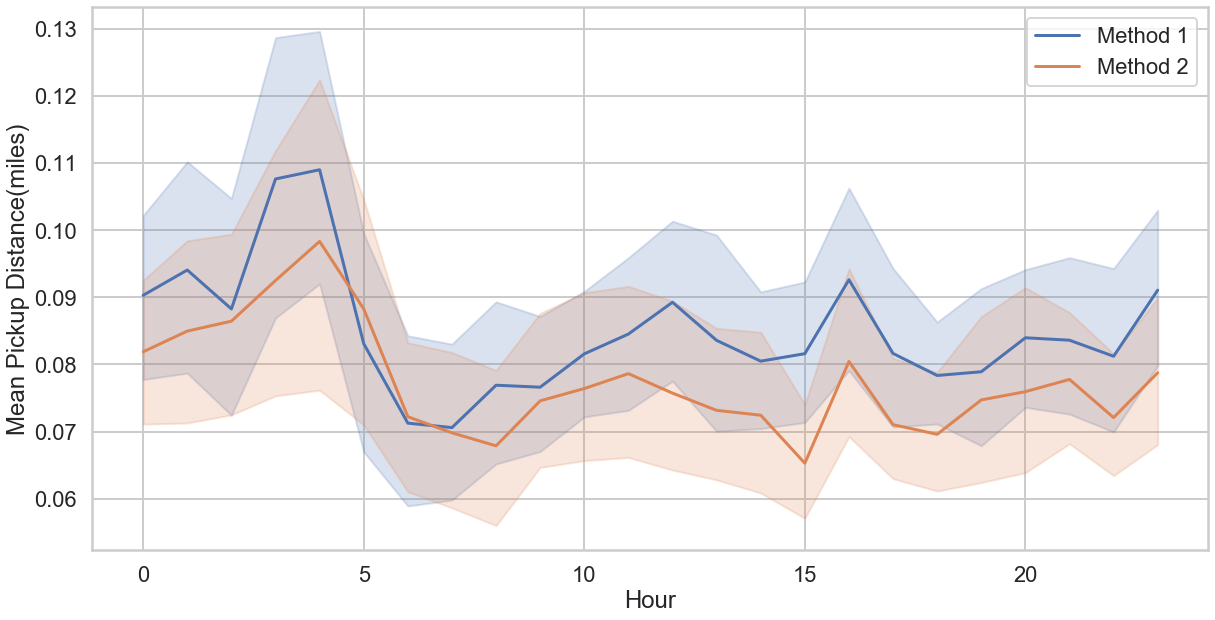

In [48]:
fig = plt.figure(figsize=(20,10))

sns.lineplot(x='Hour', y = 'Mean Pickup Dist Method_1',  data= summary_df_loc,
             label = 'Method 1')
sns.lineplot(x='Hour', y = 'Mean Pickup Dist Method_2', data= summary_df_loc,
            label = 'Method 2')
plt.ylabel('Mean Pickup Distance(miles)')

In [49]:
neighbor_efficiency = summary_df_loc.groupby(['Neighborhood'])['Method_1 Overall Efficiency'].agg(['mean']).sort_values(by=['mean'])
neighbor_efficiency = neighbor_efficiency.reset_index()
nyc_coor = [40.738, -73.98]
neighborhoods = r'./Boundaries/Neighborhood Tabulation Areas.geojson'
base_map = folium.Map(location=nyc_coor,zoom_start=11)
base_map.choropleth(geo_data=neighborhoods,
                        data=neighbor_efficiency,
                        key_on='feature.properties.ntaname',
                        columns=['Neighborhood', 'mean'],
                        fill_color='BuGn', 
                        fill_opacity=.7, 
                        line_opacity=0.5,
                        threshold_scale=[0, 30, 40, 50, 60, 100])
base_map.save('./HTML/Neighborhood_map.html')

In [50]:
# K-Means with threshold prediction

def kmeans_cluster_threshold_pred(df_train,feat_list):
    
    train = df_train[feat_list].copy()
    
    step_size = int(np.ceil((len(train)/3 - len(train)/8)/5))
    cluster_range = np.arange(int(np.ceil(len(train)/8)), int(len(train)/3),step_size)
    if len(train)<500:
        threshold = 0.0005
    else:
        x_pred = np.array([0.1, len(train)])
        threshold = model1.predict(x_pred.reshape(1,-1))[0]
    
    for i in cluster_range:
        kmeans = KMeans(n_clusters=i,n_jobs=-1,max_iter=100, random_state=0).fit(train)
        
        if kmeans.inertia_ < threshold:
            print(i,kmeans.inertia_ )
            break
    df_train['cluster'] = kmeans.labels_
    return df_train, kmeans

In [51]:
def get_mean_pu_do_dist(agg_df,df_train):
    mean_pickup_distance = []
    mean_dropoff_distance = []

    cl_range = agg_df['cluster'].nunique()
    for i in range(cl_range):
        cluster = agg_df['cluster'][i]
        df_cluster = df_train.loc[df_train['cluster']==cluster]

        pu_cent_lat = (model.cluster_centers_[cluster])[0]
        pu_cent_long = (model.cluster_centers_[cluster])[1]
        do_cent_lat = (model.cluster_centers_[cluster])[2]
        do_cent_long = (model.cluster_centers_[cluster])[3]

        pu_dist= haversine_np(pu_cent_long,pu_cent_lat,
                               df_cluster['pickup_longitude'],
                               df_cluster['pickup_latitude'] )

        do_dist = haversine_np(do_cent_long,do_cent_lat,
                               df_cluster['dropoff_longitude'],
                               df_cluster['dropoff_latitude'] )


        mean_pickup_distance.append(pu_dist.mean())
        mean_dropoff_distance.append(do_dist.mean())
    return mean_pickup_distance,mean_dropoff_distance

In [52]:
def proc_df(df,model,hour,feat_list):
    train = df_train[feat_list].copy()
    df_train['cluster'] = model.predict(train)
    agg_df= df_train.groupby(['cluster'])['passenger_count'].agg(['sum']).sort_values(['sum'], ascending=False)
    agg_df['Count']= df_train.groupby(['cluster'])['passenger_count'].agg(['count'])
    
    agg_df ['Pickup Centroid Latitude'] = model.cluster_centers_[:,0]
    agg_df ['Pickup Centroid Longitude'] = model.cluster_centers_[:,1]
    agg_df ['Dropoff Centroid Latitude'] = model.cluster_centers_[:,2]
    agg_df ['Dropoff Centroid Longitude'] = model.cluster_centers_[:,3]
    
    agg_df['trips'] = np.ceil(agg_df['sum']/4)
    base_pass_per_car = agg_df['sum']/agg_df['Count']
    clust_pass_per_car = agg_df['sum']/agg_df['trips']
    agg_df['Efficiency'] = (clust_pass_per_car-base_pass_per_car)*100/clust_pass_per_car
    agg_df['Hour'] = hour
    agg_df = agg_df.reset_index()
    agg_df['Mean Pickup Distance'],agg_df['Mean Dropoff Distance'] = get_mean_pu_do_dist(agg_df, df_train)
   
    agg_df = agg_df.sort_values(['cluster'])
    return agg_df

In [53]:
trips_grp_by_time = yc_2016_jun_wk1_proc_neigh.groupby(["Hour"]).size()
trips_grp_by_time= trips_grp_by_time.reset_index()
trips_grp_by_time = trips_grp_by_time.rename(columns={0:'Total Trips'})


In [54]:
fname='./Data/Pickled Data/Summary_DF_hour.pkl'
summary_df_hour=pd.DataFrame()
for i in range(len(trips_grp_by_time)):
    
    df_train = yc_2016_jun_wk1_proc_neigh.loc[(yc_2016_jun_wk1_proc_neigh['Hour']==trips_grp_by_time['Hour'][i])]
    df = df_train.sample(frac=0.25)
    feat_list =  ['pickup_latitude' ,'pickup_longitude','dropoff_latitude' , 'dropoff_longitude']
    df, model = kmeans_cluster_threshold_pred(df,feat_list)
    print(mean_pickup_dropoff_dist (df,model))
    summary_df_hour = pd.concat([summary_df_hour, proc_df(df_train,model,i,feat_list)])

    if i==0:
        tic = perf_counter()
  
    if (i+1)%5==0:
        
        toc = perf_counter()
        print('Processed ',i+1,'Rows in ', toc-tic, 'seconds')
        summary_df_hour.to_pickle(fname)
        tic = perf_counter()
        
                               
summary_df_hour.to_pickle(fname)
summary_df_hour.head()

2786 0.045287913980976584
(0.06331746031746033, 0.06790277777777778)
1993 0.03637662293482856
(0.08276538461538462, 0.09639551282051284)
1393 0.029388561244810586
(0.07654578754578756, 0.09712783882783885)
(0.08900203717850778, 0.10380532212885155)
(0.1358181818181818, 0.12363636363636363)
Processed  5 Rows in  104.37844189999942 seconds
546 0.018806520360382637
(0.060586765487694295, 0.09801294680551646)
1193 0.025111595164772967
(0.037433120925480866, 0.06457344607853946)
2232 0.03778836852384813
(0.03744138819094972, 0.04741957905200131)
2782 0.0496540389870373
(0.05127966263621436, 0.0702916853261681)
2976 0.05431021963997535
(0.06601754385964914, 0.06684461152882207)
Processed  10 Rows in  326.32619440000053 seconds
2975 0.055471147135229486
(0.056494969040247686, 0.07235040419676644)
3078 0.0563812765922702
(0.04822614379084968, 0.06467275541795667)
3300 0.06010504483568109
(0.07393464052287582, 0.05717075163398694)
3316 0.05994867392798902
(0.07253501400560225, 0.062352007469654

cluster  sum  Count  Pickup Centroid Latitude  \
1167        0   19     11                 40.760700   
1660        1   14      9                 40.757075   
1561        2   15     13                 40.765500   
899         3   22     18                 40.792050   
959         4   22     14                 40.750850   

      Pickup Centroid Longitude  Dropoff Centroid Latitude  \
1167                  -73.98010                  40.779100   
1660                  -73.99010                  40.772825   
1561                  -73.96890                  40.777300   
899                   -73.97370                  40.823650   
959                   -73.99325                  40.726850   

      Dropoff Centroid Longitude  trips  Efficiency  Hour  \
1167                   -73.96010    5.0   54.545455     0   
1660                   -73.99005    4.0   55.555556     0   
1561                   -73.98760    4.0   69.230769     0   
899                    -73.93990    6.0   66.666667     0   
959                    -74.00325    6.0   57.142857     0   

      Mean Pickup Distance  Mean Dropoff Distance  
1167              0.108182               0.094545  
1660              0.130000               0.063333  
1561              0.118462               0.164615  
899               0.080000               0.151111  
959               0.082857               0.110714

In [55]:
summary_df_hour['Efficiency_Scaled'] = summary_df_hour['Efficiency']/500

In [56]:
centroids_PU_Hour_list = []
for PU_Hour in summary_df_hour.Hour.sort_values().unique():
    centroids_PU_Hour_list.append(summary_df_hour.loc[summary_df_hour.Hour == PU_Hour,['Pickup Centroid Latitude', 'Pickup Centroid Longitude','Efficiency_Scaled']].groupby(['Pickup Centroid Latitude','Pickup Centroid Longitude']).mean().reset_index().values.tolist())

In [57]:
base_map = generateBaseMap(default_zoom_start=13)
HeatMapWithTime(centroids_PU_Hour_list, radius=10, gradient={0.1: 'blue', 0.4: 'lime', 0.7: 'orange', 1: 'red'}, 
                min_opacity=0.75, max_opacity=0.95, use_local_extrema=False).add_to(base_map)
base_map.save('./Data/HTML/Pickup_HeatMap_With_Time.html')


In [58]:
centroids_DO_Hour_list = []
for DO_Hour in summary_df_hour.Hour.sort_values().unique():
    centroids_DO_Hour_list.append(summary_df_hour.loc[summary_df_hour.Hour == DO_Hour,
                            ['Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Efficiency_Scaled']].groupby(['Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']).mean().reset_index().values.tolist())

In [59]:
base_map = generateBaseMap(default_zoom_start=13)
HeatMapWithTime(centroids_DO_Hour_list, radius=10, gradient={0.1: 'blue', 0.4: 'lime', 0.7: 'orange', 1: 'red'}, 
                min_opacity=0.75, max_opacity=0.95, use_local_extrema=False).add_to(base_map)

base_map.save('./Data/HTML/Dropoff_HeatMap_With_Time.html')


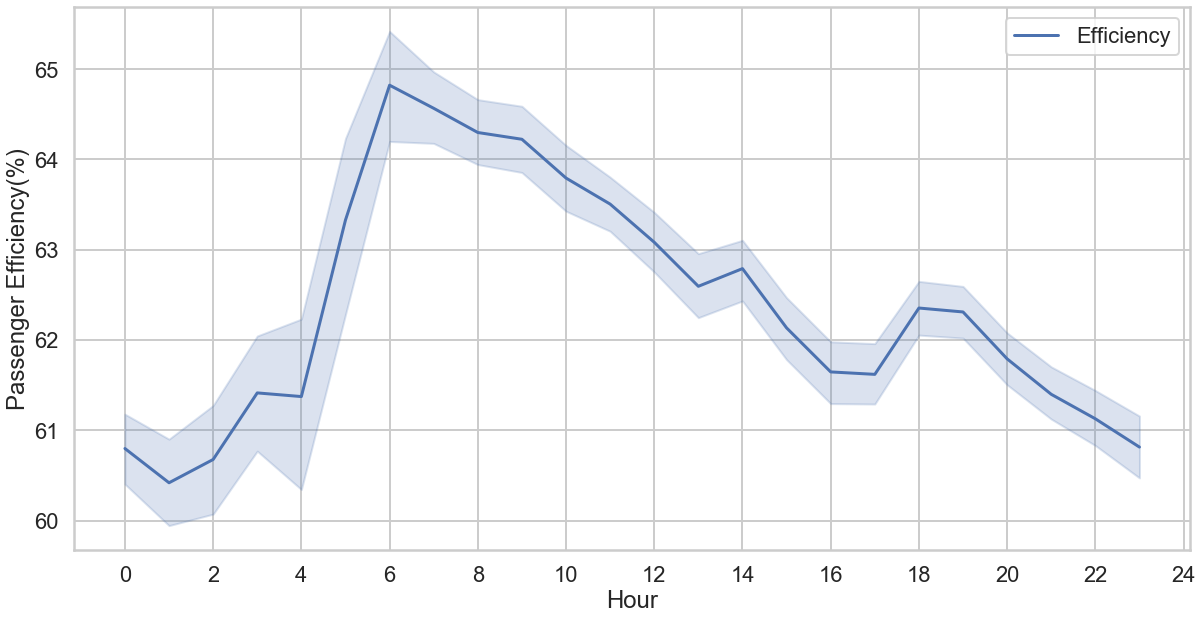

In [60]:
fig = plt.figure(figsize=(20,10))

p =sns.lineplot(x='Hour', y = 'Efficiency',  data= summary_df_hour,
             label = 'Efficiency')

plt.ylabel('Passenger Efficiency(%)')
p.xaxis.set_major_locator(MultipleLocator(2))

## Time Complexity

In [61]:
from sklearn.cluster import MeanShift
def meanshift_cluster_time(df_train,feat_list):
    
    train = df_train[feat_list].copy()
    seed = [len(train), 4]
    mean_shift = MeanShift(bandwidth=0.0039,n_jobs=1).fit(train)
        
    df_train['cluster'] = mean_shift.labels_
    return df_train, mean_shift

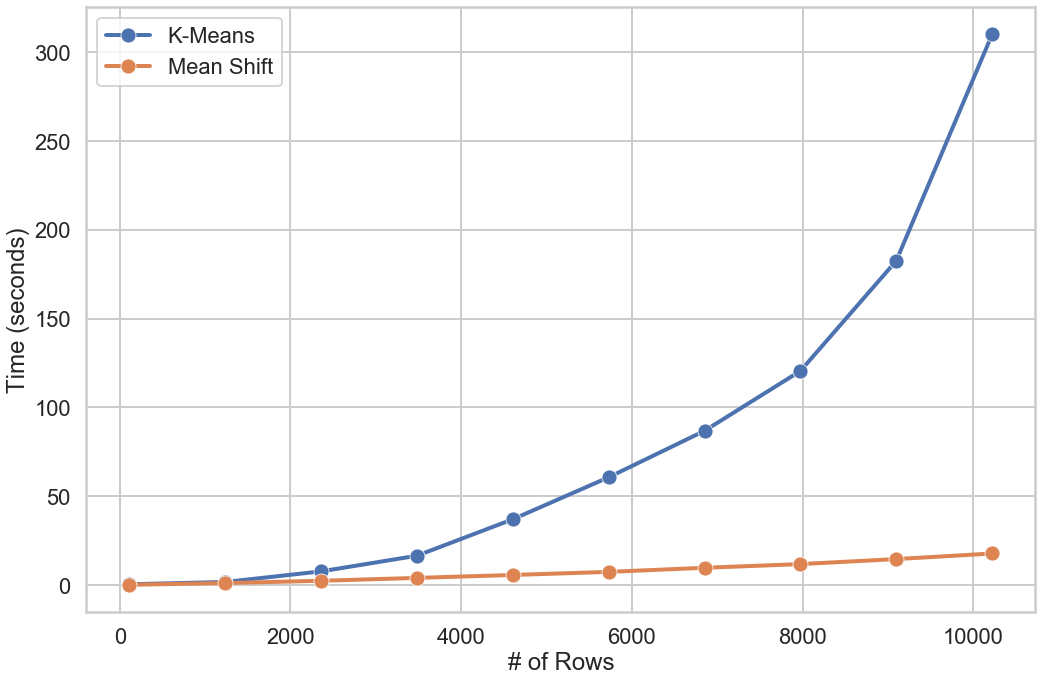

In [62]:
from time import perf_counter 
size = []
time_kmeans =[]
time_mean_shift=[]
for i in np.arange(1,100,10):
    df = pd.DataFrame()
    feat_list_m1 =  ['pickup_latitude' ,'pickup_longitude','dropoff_latitude' , 'dropoff_longitude']
    df = yc_2016_jun_wk1_proc.sample(frac=i*0.0001)
    
    tic=perf_counter()
    cluster_df_m1, kmeans_model_m1 = meanshift_cluster_time(df,feat_list_m1)
    
    toc = perf_counter()
    size.append(len(df))
    time_mean_shift.append(toc-tic)
    
    tic=perf_counter()
    
    cluster_df_m1, kmeans_model_m1 = kmeans_cluster(df,feat_list_m1)
    
    toc = perf_counter()
    time_kmeans.append(toc-tic)

figure = plt.figure(figsize=(15,10))
sns.lineplot(x=size, y =time_kmeans, linewidth=4,marker='o', label = 'K-Means')
sns.lineplot(x=size, y =time_mean_shift, linewidth=4,marker='o', label = 'Mean Shift')
plt.xlabel('# of Rows')
plt.ylabel('Time (seconds)')
plt.tight_layout()
plt.show()